In [49]:
import math
import pandas as pd
import numpy as np
import igraph 
import itertools
import matplotlib.pyplot as plt
from notears_custom import utils
from scipy import stats, linalg
from itertools import chain, combinations, product
from sklearn.linear_model import LinearRegression, Lasso
import math
%matplotlib inline

In [50]:
class dag():
    
    def __init__(self, m):
        '''
        m is a pandas DataFrame conaining an adjacency matrix
        '''
        self.m = m
        self.nodes = self.m.columns.values
        self.lags = np.array([n for n in self.nodes if '_1' in n])
        if not all(self.m.columns.values == self.m.index.values):
            raise ValueError('Invalid adjacency matrix (columns and rows are not the same)')
        self.directed = self.directed()

            
    def parents(self, n):
        '''
        n is a node in the graph
        '''
        if n not in self.nodes:
            raise ValueError('n is not in graph')
        return self.m.loc[self.m.loc[:,n] != 0, n].index.values
    
    
    def children(self, n):
        '''
        n is a node in the graph
        '''
        if n not in self.nodes:
            raise ValueError('n is not in graph')
        return self.m.loc[:,self.m.loc[n,:] != 0].columns.values
    
    
    def directed(self):
        return utils.is_dag(self.m.values)
        
    
    def depth(self, n):
        '''
        n is a node in the graph
        return the length of the shortest path to a root node
        '''
        if not self.directed:
            raise ValueError('Cannot compute depth, graph is undirected')
        if len(self.parents(n)) == 0:
            return 0
        else:
            return 1 + max([self.depth(p) for p in self.parents(n)])
    
    
    def root_nodes(self):
        return np.array([n for n in self.nodes if len(self.parents(n)) == 0])
        
        
    def isolated_nodes(self):
        return np.array([n for n in d.nodes if (len(d.parents(n)) == 0) & (len(d.children(n)) == 0)])
    
    
    def connected_roots(self):
        return np.array([n for n in d.nodes if (len(d.parents(n)) == 0) & (len(d.children(n)) > 0)])
    
    
    def structure(self):
        M = self.m.copy()
        M[M != 0] = 1
        return M
    
    
    def shd(self, d):
        try:
            return utils.count_accuracy(d.structure().values, self.structure().values)['shd']
        except ValueError as e:
            # Graph is not directed
            return None
    
    
    def impute(self, values):
        na_nodes = values[values.isna()]
        depth = 0
        try:
            max_depth = max([self.depth(n) for n in self.nodes])
        except ValueError as e:
            print('Cannot impute values as graph is not directed')
            raise e
        while depth <= max_depth:
            for node in na_nodes.index:
                if self.depth(node) == depth:
                    values[node] = np.dot(self.m.loc[:,node], values.fillna(0))
            depth += 1
        return values


    def calculate_irf(self, x_0, T=250, verbose=False):
        if verbose:
            print('Simulating irf...')
        for lag in self.lags:
            x_0[lag] = 0
        irf = pd.DataFrame([self.impute(x_0)], columns=self.nodes)
        for t in range(T-1):
            if verbose:
                print('Simulating t={} of {} ({}%)'.format(t+1, T, np.round(100 * ((t+1)/T), decimals=2)))
            nr = pd.Series(np.full(len(self.nodes), np.nan), index=self.nodes)
            for lag in self.lags:
                nr[lag] = irf.iloc[-1,:][lag.rstrip('_1')]
            nr = self.impute(nr)    
            irf = irf.append(nr, ignore_index=True)
        irf.loc[:,'t'] = range(T)
        irf.set_index('t', inplace=True)
        irf.drop(self.lags, axis=1, inplace=True)
        return irf


    def plot_irf(self, irf, layout=None):
        if layout is None:
            side = math.ceil(math.sqrt(len(irf.columns)))
            layout = (side, side)
        axes = irf.plot(subplots=True, layout=layout, 
                        color="black", legend=False)
        for ax, name in zip(axes.flatten(), irf.columns.values):
            ax.axhline(y=0, color="red")
            ax.set_title(name)
        return plt
    
    
    def plot_structure(self):
        M = self.m.values
        g = igraph.Graph.Adjacency((M != 0.0).tolist())
        g.es['weight'] = M[M.nonzero()]
        g.vs['label'] = self.nodes
        g.vs['color'] = 'white'
        g.vs['size'] = 45
        return g

In [108]:
def partial_correlation(y, x, z, data):
    if len(z) == 0:
        pcorr = stats.pearsonr(data[y], data[x])
    else:
        model_y = LinearRegression(fit_intercept=False, normalize=True)
        model_x = LinearRegression(fit_intercept=False, normalize=True)
        model_y.fit(data[z], data[y])
        model_x.fit(data[z], data[x])
        resid_y = data[y] - model_y.predict(data[z])
        resid_x = data[x] - model_x.predict(data[z])
    
        pcorr = stats.pearsonr(resid_y, resid_x) # return p-value
    
    return pcorr


def fisher_z(pcorr, z, data):
    z = math.sqrt(len(data) - len(z) - 3)*math.log((1+pcorr)/(1-pcorr))/2
    pval = 2*(1-stats.norm.cdf(abs(z)))
    return (z, pval)


def powerset(iterable):
    s = list(iterable)
    pset = list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))
    variables = iterable[:np.int64(len(iterable)/2)]
    pairs = {}
    for v in variables:
        pairs[v] = v+'_1'
        pairs[v+'_1'] = v
    pset = [list(s) for s in pset if all([pairs[n] not in s for n in s])]
    return pset


def choose_states(data, max_states=5, alpha=0.05, verbose=False):
    results = pd.DataFrame(columns=['valid', 'states', 'mean_pval', 'max_pval', 'min_pval', 'tests'])
    lags = data.columns.values[np.int64(len(data.columns.values)/2):]
    for states in powerset(data.columns.values):
        if len(states) > max_states:
            break
        controls = [n for n in data.columns.values if n not in states and n not in lags]
        if len(controls) < 2:
            break
        if verbose: 
            print('Calculating partial correlations for {}'.format(list(states)))
        tests = []
        for (x, y) in combinations(controls, 2):
            p = partial_correlation(x, y, states, data=data)
            pcorr = p[0]
            pval = p[1]
            tests.append({'x': x,
                          'y': y,
                          'states': states,
                          'pcorr': pcorr,
                          'pval': pval})
        m = len(tests)
        valid = all([test['pval'] > (alpha/2)/m for test in tests])
        if valid and verbose:
            print('Valid states found: {}'.format(states))
        result = {'valid': valid,
                  'states': list(states),
                  'nstates': len(list(states)),
                  'mean_pval': np.mean([test['pval'] for test in tests]),
                  'max_pval': max([test['pval'] for test in tests]),
                  'min_pval': min([test['pval'] for test in tests]),
                  'tests': tests}
        results = results.append(result, ignore_index=True)
    return results


def make_adjacency(exo_states, endo_states, controls, data):
    data_names = data.columns.values.tolist()
    data_current = [name for name in data_names if '_1' not in name]
    implied_names = exo_states + endo_states + controls
    
    for name in implied_names:
        if name not in data_names:
            raise ValueError('Name {} missing from data'.format(name))
        if str(name) + '_1' not in data_names:
            raise ValueError('Lag of name {} missing from data'.format(name))
        if any([name not in data_names for name in implied_names]) or any([name not in implied_names for name in data_current]):
            print(data_current)
            print(implied_names)
            raise ValueError('Implied names and data do not align')
    
    names = data_names
    d = len(data.columns)
    result = pd.DataFrame(np.zeros((d, d)), columns=names, index=names)
    
    for exo_state in exo_states:
        model = LinearRegression(fit_intercept=False)
        model.fit(data[[exo_state + '_1']], data[exo_state])
        result.loc[exo_state + '_1', exo_state] = model.coef_[0]
        
    for endo in endo_states + controls:
        regressors = [es + '_1' for es in endo_states] + exo_states
        model = LinearRegression(fit_intercept=False)
        model.fit(data[regressors], data[endo])
        coefs = {}
        for i in range(len(regressors)):
            coefs[regressors[i]] = model.coef_[i]
        for x in regressors:
            result.loc[x, endo] = coefs[x]
    
    return result


def make_roles(states, data):
    exo_names = []
    endo_names = []
    for state in states:
        if '_1' in str(state):
            endo_names.append(str(state).rstrip('_1'))
        else:
            exo_names.append(str(state))
    controls = [name for name in data.columns.values if '_1' not in str(name) and name not in exo_names + endo_names]
    
    return exo_names, endo_names, controls

In [53]:
data = pd.read_csv('/home/emmet/Documents/bayesian/bayesian_networks/data/real_data.csv')
# data = data.drop(['eps_g', 'eps_z'], axis=1)
data = data.drop(list(['DATE', 'dk']), axis=1)
data.columns = [col.replace(" ", "") for col in data.columns]
data = data.iloc[:,1:]

# data = data.iloc[:1000,:]
# data = data.apply(lambda x: x - x.mean())
# data = data.applymap(lambda x: x + np.random.normal(scale=1))

shift_vars = data.columns.values
shift = data.loc[:,shift_vars].shift()
shift.columns = [str(col) + '_1' for col in shift.columns]
data = pd.concat([data, shift], axis=1)
data = data.iloc[1:,:]

# data = data[['rm', 'rk', 'z', 'y', 'w', 'u', 'c', 'i', 'g',
#              'rm_1', 'rk_1', 'z_1', 'y_1', 'w_1', 'u_1', 'c_1', 'i_1', 'g_1']]

In [54]:
results = choose_states(data, max_states=4, alpha=0.05, verbose=True)

Calculating partial correlations for []
Calculating partial correlations for ['rm']
Calculating partial correlations for ['rb']
Calculating partial correlations for ['g']
Calculating partial correlations for ['y']
Calculating partial correlations for ['i']
Calculating partial correlations for ['w']
Calculating partial correlations for ['n']
Calculating partial correlations for ['rk']
Calculating partial correlations for ['z']
Calculating partial correlations for ['u']
Calculating partial correlations for ['l']
Calculating partial correlations for ['c']
Calculating partial correlations for ['rm_1']
Calculating partial correlations for ['rb_1']
Calculating partial correlations for ['g_1']
Calculating partial correlations for ['y_1']
Calculating partial correlations for ['i_1']
Calculating partial correlations for ['w_1']
Calculating partial correlations for ['n_1']
Calculating partial correlations for ['rk_1']
Calculating partial correlations for ['z_1']
Calculating partial correlations 

Calculating partial correlations for ['rk', 'z_1']
Calculating partial correlations for ['rk', 'u_1']
Calculating partial correlations for ['rk', 'l_1']
Calculating partial correlations for ['rk', 'c_1']
Calculating partial correlations for ['z', 'u']
Calculating partial correlations for ['z', 'l']
Calculating partial correlations for ['z', 'c']
Calculating partial correlations for ['z', 'rm_1']
Calculating partial correlations for ['z', 'rb_1']
Calculating partial correlations for ['z', 'g_1']
Calculating partial correlations for ['z', 'y_1']
Calculating partial correlations for ['z', 'i_1']
Calculating partial correlations for ['z', 'w_1']
Calculating partial correlations for ['z', 'n_1']
Calculating partial correlations for ['z', 'rk_1']
Calculating partial correlations for ['z', 'u_1']
Calculating partial correlations for ['z', 'l_1']
Calculating partial correlations for ['z', 'c_1']
Calculating partial correlations for ['u', 'l']
Calculating partial correlations for ['u', 'c']
Cal

Calculating partial correlations for ['rm', 'g', 'c_1']
Calculating partial correlations for ['rm', 'y', 'i']
Calculating partial correlations for ['rm', 'y', 'w']
Calculating partial correlations for ['rm', 'y', 'n']
Calculating partial correlations for ['rm', 'y', 'rk']
Calculating partial correlations for ['rm', 'y', 'z']
Calculating partial correlations for ['rm', 'y', 'u']
Calculating partial correlations for ['rm', 'y', 'l']
Calculating partial correlations for ['rm', 'y', 'c']
Calculating partial correlations for ['rm', 'y', 'rb_1']
Calculating partial correlations for ['rm', 'y', 'g_1']
Calculating partial correlations for ['rm', 'y', 'i_1']
Calculating partial correlations for ['rm', 'y', 'w_1']
Calculating partial correlations for ['rm', 'y', 'n_1']
Calculating partial correlations for ['rm', 'y', 'rk_1']
Calculating partial correlations for ['rm', 'y', 'z_1']
Calculating partial correlations for ['rm', 'y', 'u_1']
Calculating partial correlations for ['rm', 'y', 'l_1']
Calcu

Calculating partial correlations for ['rm', 'y_1', 'w_1']
Calculating partial correlations for ['rm', 'y_1', 'n_1']
Calculating partial correlations for ['rm', 'y_1', 'rk_1']
Calculating partial correlations for ['rm', 'y_1', 'z_1']
Calculating partial correlations for ['rm', 'y_1', 'u_1']
Calculating partial correlations for ['rm', 'y_1', 'l_1']
Calculating partial correlations for ['rm', 'y_1', 'c_1']
Calculating partial correlations for ['rm', 'i_1', 'w_1']
Calculating partial correlations for ['rm', 'i_1', 'n_1']
Calculating partial correlations for ['rm', 'i_1', 'rk_1']
Calculating partial correlations for ['rm', 'i_1', 'z_1']
Calculating partial correlations for ['rm', 'i_1', 'u_1']
Calculating partial correlations for ['rm', 'i_1', 'l_1']
Calculating partial correlations for ['rm', 'i_1', 'c_1']
Calculating partial correlations for ['rm', 'w_1', 'n_1']
Calculating partial correlations for ['rm', 'w_1', 'rk_1']
Calculating partial correlations for ['rm', 'w_1', 'z_1']
Calculating

Calculating partial correlations for ['rb', 'z', 'c_1']
Calculating partial correlations for ['rb', 'u', 'l']
Calculating partial correlations for ['rb', 'u', 'c']
Calculating partial correlations for ['rb', 'u', 'rm_1']
Calculating partial correlations for ['rb', 'u', 'g_1']
Calculating partial correlations for ['rb', 'u', 'y_1']
Calculating partial correlations for ['rb', 'u', 'i_1']
Calculating partial correlations for ['rb', 'u', 'w_1']
Calculating partial correlations for ['rb', 'u', 'n_1']
Calculating partial correlations for ['rb', 'u', 'rk_1']
Calculating partial correlations for ['rb', 'u', 'z_1']
Calculating partial correlations for ['rb', 'u', 'l_1']
Calculating partial correlations for ['rb', 'u', 'c_1']
Calculating partial correlations for ['rb', 'l', 'c']
Calculating partial correlations for ['rb', 'l', 'rm_1']
Calculating partial correlations for ['rb', 'l', 'g_1']
Calculating partial correlations for ['rb', 'l', 'y_1']
Calculating partial correlations for ['rb', 'l', 'i

Calculating partial correlations for ['g', 'n', 'y_1']
Calculating partial correlations for ['g', 'n', 'i_1']
Calculating partial correlations for ['g', 'n', 'w_1']
Calculating partial correlations for ['g', 'n', 'rk_1']
Calculating partial correlations for ['g', 'n', 'z_1']
Calculating partial correlations for ['g', 'n', 'u_1']
Calculating partial correlations for ['g', 'n', 'l_1']
Calculating partial correlations for ['g', 'n', 'c_1']
Calculating partial correlations for ['g', 'rk', 'z']
Calculating partial correlations for ['g', 'rk', 'u']
Calculating partial correlations for ['g', 'rk', 'l']
Calculating partial correlations for ['g', 'rk', 'c']
Calculating partial correlations for ['g', 'rk', 'rm_1']
Calculating partial correlations for ['g', 'rk', 'rb_1']
Calculating partial correlations for ['g', 'rk', 'y_1']
Calculating partial correlations for ['g', 'rk', 'i_1']
Calculating partial correlations for ['g', 'rk', 'w_1']
Calculating partial correlations for ['g', 'rk', 'n_1']
Calcu

Calculating partial correlations for ['y', 'w', 'rb_1']
Calculating partial correlations for ['y', 'w', 'g_1']
Calculating partial correlations for ['y', 'w', 'i_1']
Calculating partial correlations for ['y', 'w', 'n_1']
Calculating partial correlations for ['y', 'w', 'rk_1']
Calculating partial correlations for ['y', 'w', 'z_1']
Calculating partial correlations for ['y', 'w', 'u_1']
Calculating partial correlations for ['y', 'w', 'l_1']
Calculating partial correlations for ['y', 'w', 'c_1']
Calculating partial correlations for ['y', 'n', 'rk']
Calculating partial correlations for ['y', 'n', 'z']
Calculating partial correlations for ['y', 'n', 'u']
Calculating partial correlations for ['y', 'n', 'l']
Calculating partial correlations for ['y', 'n', 'c']
Calculating partial correlations for ['y', 'n', 'rm_1']
Calculating partial correlations for ['y', 'n', 'rb_1']
Calculating partial correlations for ['y', 'n', 'g_1']
Calculating partial correlations for ['y', 'n', 'i_1']
Calculating par

Calculating partial correlations for ['i', 'w', 'g_1']
Calculating partial correlations for ['i', 'w', 'y_1']
Calculating partial correlations for ['i', 'w', 'n_1']
Calculating partial correlations for ['i', 'w', 'rk_1']
Calculating partial correlations for ['i', 'w', 'z_1']
Calculating partial correlations for ['i', 'w', 'u_1']
Calculating partial correlations for ['i', 'w', 'l_1']
Calculating partial correlations for ['i', 'w', 'c_1']
Calculating partial correlations for ['i', 'n', 'rk']
Calculating partial correlations for ['i', 'n', 'z']
Calculating partial correlations for ['i', 'n', 'u']
Calculating partial correlations for ['i', 'n', 'l']
Calculating partial correlations for ['i', 'n', 'c']
Calculating partial correlations for ['i', 'n', 'rm_1']
Calculating partial correlations for ['i', 'n', 'rb_1']
Calculating partial correlations for ['i', 'n', 'g_1']
Calculating partial correlations for ['i', 'n', 'y_1']
Calculating partial correlations for ['i', 'n', 'w_1']
Calculating part

Calculating partial correlations for ['w', 'n', 'rk_1']
Calculating partial correlations for ['w', 'n', 'z_1']
Calculating partial correlations for ['w', 'n', 'u_1']
Calculating partial correlations for ['w', 'n', 'l_1']
Calculating partial correlations for ['w', 'n', 'c_1']
Calculating partial correlations for ['w', 'rk', 'z']
Calculating partial correlations for ['w', 'rk', 'u']
Calculating partial correlations for ['w', 'rk', 'l']
Calculating partial correlations for ['w', 'rk', 'c']
Calculating partial correlations for ['w', 'rk', 'rm_1']
Calculating partial correlations for ['w', 'rk', 'rb_1']
Calculating partial correlations for ['w', 'rk', 'g_1']
Calculating partial correlations for ['w', 'rk', 'y_1']
Calculating partial correlations for ['w', 'rk', 'i_1']
Calculating partial correlations for ['w', 'rk', 'n_1']
Calculating partial correlations for ['w', 'rk', 'z_1']
Calculating partial correlations for ['w', 'rk', 'u_1']
Calculating partial correlations for ['w', 'rk', 'l_1']
Ca

Calculating partial correlations for ['n', 'u', 'c']
Calculating partial correlations for ['n', 'u', 'rm_1']
Calculating partial correlations for ['n', 'u', 'rb_1']
Calculating partial correlations for ['n', 'u', 'g_1']
Calculating partial correlations for ['n', 'u', 'y_1']
Calculating partial correlations for ['n', 'u', 'i_1']
Calculating partial correlations for ['n', 'u', 'w_1']
Calculating partial correlations for ['n', 'u', 'rk_1']
Calculating partial correlations for ['n', 'u', 'z_1']
Calculating partial correlations for ['n', 'u', 'l_1']
Calculating partial correlations for ['n', 'u', 'c_1']
Calculating partial correlations for ['n', 'l', 'c']
Calculating partial correlations for ['n', 'l', 'rm_1']
Calculating partial correlations for ['n', 'l', 'rb_1']
Calculating partial correlations for ['n', 'l', 'g_1']
Calculating partial correlations for ['n', 'l', 'y_1']
Calculating partial correlations for ['n', 'l', 'i_1']
Calculating partial correlations for ['n', 'l', 'w_1']
Calculati

Calculating partial correlations for ['rk', 'rb_1', 'i_1']
Calculating partial correlations for ['rk', 'rb_1', 'w_1']
Calculating partial correlations for ['rk', 'rb_1', 'n_1']
Calculating partial correlations for ['rk', 'rb_1', 'z_1']
Calculating partial correlations for ['rk', 'rb_1', 'u_1']
Calculating partial correlations for ['rk', 'rb_1', 'l_1']
Calculating partial correlations for ['rk', 'rb_1', 'c_1']
Calculating partial correlations for ['rk', 'g_1', 'y_1']
Calculating partial correlations for ['rk', 'g_1', 'i_1']
Calculating partial correlations for ['rk', 'g_1', 'w_1']
Calculating partial correlations for ['rk', 'g_1', 'n_1']
Calculating partial correlations for ['rk', 'g_1', 'z_1']
Calculating partial correlations for ['rk', 'g_1', 'u_1']
Calculating partial correlations for ['rk', 'g_1', 'l_1']
Calculating partial correlations for ['rk', 'g_1', 'c_1']
Calculating partial correlations for ['rk', 'y_1', 'i_1']
Calculating partial correlations for ['rk', 'y_1', 'w_1']
Calcula

Calculating partial correlations for ['u', 'c', 'g_1']
Calculating partial correlations for ['u', 'c', 'y_1']
Calculating partial correlations for ['u', 'c', 'i_1']
Calculating partial correlations for ['u', 'c', 'w_1']
Calculating partial correlations for ['u', 'c', 'n_1']
Calculating partial correlations for ['u', 'c', 'rk_1']
Calculating partial correlations for ['u', 'c', 'z_1']
Calculating partial correlations for ['u', 'c', 'l_1']
Calculating partial correlations for ['u', 'rm_1', 'rb_1']
Calculating partial correlations for ['u', 'rm_1', 'g_1']
Calculating partial correlations for ['u', 'rm_1', 'y_1']
Calculating partial correlations for ['u', 'rm_1', 'i_1']
Calculating partial correlations for ['u', 'rm_1', 'w_1']
Calculating partial correlations for ['u', 'rm_1', 'n_1']
Calculating partial correlations for ['u', 'rm_1', 'rk_1']
Calculating partial correlations for ['u', 'rm_1', 'z_1']
Calculating partial correlations for ['u', 'rm_1', 'l_1']
Calculating partial correlations fo

Calculating partial correlations for ['c', 'rb_1', 'rk_1']
Calculating partial correlations for ['c', 'rb_1', 'z_1']
Calculating partial correlations for ['c', 'rb_1', 'u_1']
Calculating partial correlations for ['c', 'rb_1', 'l_1']
Calculating partial correlations for ['c', 'g_1', 'y_1']
Calculating partial correlations for ['c', 'g_1', 'i_1']
Calculating partial correlations for ['c', 'g_1', 'w_1']
Calculating partial correlations for ['c', 'g_1', 'n_1']
Calculating partial correlations for ['c', 'g_1', 'rk_1']
Calculating partial correlations for ['c', 'g_1', 'z_1']
Calculating partial correlations for ['c', 'g_1', 'u_1']
Calculating partial correlations for ['c', 'g_1', 'l_1']
Calculating partial correlations for ['c', 'y_1', 'i_1']
Calculating partial correlations for ['c', 'y_1', 'w_1']
Calculating partial correlations for ['c', 'y_1', 'n_1']
Calculating partial correlations for ['c', 'y_1', 'rk_1']
Calculating partial correlations for ['c', 'y_1', 'z_1']
Calculating partial corr

Calculating partial correlations for ['rb_1', 'u_1', 'c_1']
Calculating partial correlations for ['rb_1', 'l_1', 'c_1']
Calculating partial correlations for ['g_1', 'y_1', 'i_1']
Calculating partial correlations for ['g_1', 'y_1', 'w_1']
Calculating partial correlations for ['g_1', 'y_1', 'n_1']
Calculating partial correlations for ['g_1', 'y_1', 'rk_1']
Calculating partial correlations for ['g_1', 'y_1', 'z_1']
Calculating partial correlations for ['g_1', 'y_1', 'u_1']
Calculating partial correlations for ['g_1', 'y_1', 'l_1']
Calculating partial correlations for ['g_1', 'y_1', 'c_1']
Calculating partial correlations for ['g_1', 'i_1', 'w_1']
Calculating partial correlations for ['g_1', 'i_1', 'n_1']
Calculating partial correlations for ['g_1', 'i_1', 'rk_1']
Calculating partial correlations for ['g_1', 'i_1', 'z_1']
Calculating partial correlations for ['g_1', 'i_1', 'u_1']
Calculating partial correlations for ['g_1', 'i_1', 'l_1']
Calculating partial correlations for ['g_1', 'i_1', 

Calculating partial correlations for ['rm', 'rb', 'g', 'l_1']
Calculating partial correlations for ['rm', 'rb', 'g', 'c_1']
Calculating partial correlations for ['rm', 'rb', 'y', 'i']
Calculating partial correlations for ['rm', 'rb', 'y', 'w']
Calculating partial correlations for ['rm', 'rb', 'y', 'n']
Calculating partial correlations for ['rm', 'rb', 'y', 'rk']
Calculating partial correlations for ['rm', 'rb', 'y', 'z']
Calculating partial correlations for ['rm', 'rb', 'y', 'u']
Calculating partial correlations for ['rm', 'rb', 'y', 'l']
Calculating partial correlations for ['rm', 'rb', 'y', 'c']
Calculating partial correlations for ['rm', 'rb', 'y', 'g_1']
Calculating partial correlations for ['rm', 'rb', 'y', 'i_1']
Calculating partial correlations for ['rm', 'rb', 'y', 'w_1']
Calculating partial correlations for ['rm', 'rb', 'y', 'n_1']
Calculating partial correlations for ['rm', 'rb', 'y', 'rk_1']
Calculating partial correlations for ['rm', 'rb', 'y', 'z_1']
Calculating partial co

Calculating partial correlations for ['rm', 'rb', 'y_1', 'u_1']
Calculating partial correlations for ['rm', 'rb', 'y_1', 'l_1']
Calculating partial correlations for ['rm', 'rb', 'y_1', 'c_1']
Calculating partial correlations for ['rm', 'rb', 'i_1', 'w_1']
Calculating partial correlations for ['rm', 'rb', 'i_1', 'n_1']
Calculating partial correlations for ['rm', 'rb', 'i_1', 'rk_1']
Calculating partial correlations for ['rm', 'rb', 'i_1', 'z_1']
Calculating partial correlations for ['rm', 'rb', 'i_1', 'u_1']
Calculating partial correlations for ['rm', 'rb', 'i_1', 'l_1']
Calculating partial correlations for ['rm', 'rb', 'i_1', 'c_1']
Calculating partial correlations for ['rm', 'rb', 'w_1', 'n_1']
Calculating partial correlations for ['rm', 'rb', 'w_1', 'rk_1']
Calculating partial correlations for ['rm', 'rb', 'w_1', 'z_1']
Calculating partial correlations for ['rm', 'rb', 'w_1', 'u_1']
Calculating partial correlations for ['rm', 'rb', 'w_1', 'l_1']
Calculating partial correlations for [

Calculating partial correlations for ['rm', 'g', 'l', 'i_1']
Calculating partial correlations for ['rm', 'g', 'l', 'w_1']
Calculating partial correlations for ['rm', 'g', 'l', 'n_1']
Calculating partial correlations for ['rm', 'g', 'l', 'rk_1']
Calculating partial correlations for ['rm', 'g', 'l', 'z_1']
Calculating partial correlations for ['rm', 'g', 'l', 'u_1']
Calculating partial correlations for ['rm', 'g', 'l', 'c_1']
Calculating partial correlations for ['rm', 'g', 'c', 'rb_1']
Calculating partial correlations for ['rm', 'g', 'c', 'y_1']
Calculating partial correlations for ['rm', 'g', 'c', 'i_1']
Calculating partial correlations for ['rm', 'g', 'c', 'w_1']
Calculating partial correlations for ['rm', 'g', 'c', 'n_1']
Calculating partial correlations for ['rm', 'g', 'c', 'rk_1']
Calculating partial correlations for ['rm', 'g', 'c', 'z_1']
Calculating partial correlations for ['rm', 'g', 'c', 'u_1']
Calculating partial correlations for ['rm', 'g', 'c', 'l_1']
Calculating partial c

Calculating partial correlations for ['rm', 'y', 'u', 'rb_1']
Calculating partial correlations for ['rm', 'y', 'u', 'g_1']
Calculating partial correlations for ['rm', 'y', 'u', 'i_1']
Calculating partial correlations for ['rm', 'y', 'u', 'w_1']
Calculating partial correlations for ['rm', 'y', 'u', 'n_1']
Calculating partial correlations for ['rm', 'y', 'u', 'rk_1']
Calculating partial correlations for ['rm', 'y', 'u', 'z_1']
Calculating partial correlations for ['rm', 'y', 'u', 'l_1']
Calculating partial correlations for ['rm', 'y', 'u', 'c_1']
Calculating partial correlations for ['rm', 'y', 'l', 'c']
Calculating partial correlations for ['rm', 'y', 'l', 'rb_1']
Calculating partial correlations for ['rm', 'y', 'l', 'g_1']
Calculating partial correlations for ['rm', 'y', 'l', 'i_1']
Calculating partial correlations for ['rm', 'y', 'l', 'w_1']
Calculating partial correlations for ['rm', 'y', 'l', 'n_1']
Calculating partial correlations for ['rm', 'y', 'l', 'rk_1']
Calculating partial co

Calculating partial correlations for ['rm', 'i', 'u', 'n_1']
Calculating partial correlations for ['rm', 'i', 'u', 'rk_1']
Calculating partial correlations for ['rm', 'i', 'u', 'z_1']
Calculating partial correlations for ['rm', 'i', 'u', 'l_1']
Calculating partial correlations for ['rm', 'i', 'u', 'c_1']
Calculating partial correlations for ['rm', 'i', 'l', 'c']
Calculating partial correlations for ['rm', 'i', 'l', 'rb_1']
Calculating partial correlations for ['rm', 'i', 'l', 'g_1']
Calculating partial correlations for ['rm', 'i', 'l', 'y_1']
Calculating partial correlations for ['rm', 'i', 'l', 'w_1']
Calculating partial correlations for ['rm', 'i', 'l', 'n_1']
Calculating partial correlations for ['rm', 'i', 'l', 'rk_1']
Calculating partial correlations for ['rm', 'i', 'l', 'z_1']
Calculating partial correlations for ['rm', 'i', 'l', 'u_1']
Calculating partial correlations for ['rm', 'i', 'l', 'c_1']
Calculating partial correlations for ['rm', 'i', 'c', 'rb_1']
Calculating partial co

Calculating partial correlations for ['rm', 'w', 'c', 'n_1']
Calculating partial correlations for ['rm', 'w', 'c', 'rk_1']
Calculating partial correlations for ['rm', 'w', 'c', 'z_1']
Calculating partial correlations for ['rm', 'w', 'c', 'u_1']
Calculating partial correlations for ['rm', 'w', 'c', 'l_1']
Calculating partial correlations for ['rm', 'w', 'rb_1', 'g_1']
Calculating partial correlations for ['rm', 'w', 'rb_1', 'y_1']
Calculating partial correlations for ['rm', 'w', 'rb_1', 'i_1']
Calculating partial correlations for ['rm', 'w', 'rb_1', 'n_1']
Calculating partial correlations for ['rm', 'w', 'rb_1', 'rk_1']
Calculating partial correlations for ['rm', 'w', 'rb_1', 'z_1']
Calculating partial correlations for ['rm', 'w', 'rb_1', 'u_1']
Calculating partial correlations for ['rm', 'w', 'rb_1', 'l_1']
Calculating partial correlations for ['rm', 'w', 'rb_1', 'c_1']
Calculating partial correlations for ['rm', 'w', 'g_1', 'y_1']
Calculating partial correlations for ['rm', 'w', 'g_1'

Calculating partial correlations for ['rm', 'n', 'i_1', 'u_1']
Calculating partial correlations for ['rm', 'n', 'i_1', 'l_1']
Calculating partial correlations for ['rm', 'n', 'i_1', 'c_1']
Calculating partial correlations for ['rm', 'n', 'w_1', 'rk_1']
Calculating partial correlations for ['rm', 'n', 'w_1', 'z_1']
Calculating partial correlations for ['rm', 'n', 'w_1', 'u_1']
Calculating partial correlations for ['rm', 'n', 'w_1', 'l_1']
Calculating partial correlations for ['rm', 'n', 'w_1', 'c_1']
Calculating partial correlations for ['rm', 'n', 'rk_1', 'z_1']
Calculating partial correlations for ['rm', 'n', 'rk_1', 'u_1']
Calculating partial correlations for ['rm', 'n', 'rk_1', 'l_1']
Calculating partial correlations for ['rm', 'n', 'rk_1', 'c_1']
Calculating partial correlations for ['rm', 'n', 'z_1', 'u_1']
Calculating partial correlations for ['rm', 'n', 'z_1', 'l_1']
Calculating partial correlations for ['rm', 'n', 'z_1', 'c_1']
Calculating partial correlations for ['rm', 'n', '

Calculating partial correlations for ['rm', 'z', 'c', 'n_1']
Calculating partial correlations for ['rm', 'z', 'c', 'rk_1']
Calculating partial correlations for ['rm', 'z', 'c', 'u_1']
Calculating partial correlations for ['rm', 'z', 'c', 'l_1']
Calculating partial correlations for ['rm', 'z', 'rb_1', 'g_1']
Calculating partial correlations for ['rm', 'z', 'rb_1', 'y_1']
Calculating partial correlations for ['rm', 'z', 'rb_1', 'i_1']
Calculating partial correlations for ['rm', 'z', 'rb_1', 'w_1']
Calculating partial correlations for ['rm', 'z', 'rb_1', 'n_1']
Calculating partial correlations for ['rm', 'z', 'rb_1', 'rk_1']
Calculating partial correlations for ['rm', 'z', 'rb_1', 'u_1']
Calculating partial correlations for ['rm', 'z', 'rb_1', 'l_1']
Calculating partial correlations for ['rm', 'z', 'rb_1', 'c_1']
Calculating partial correlations for ['rm', 'z', 'g_1', 'y_1']
Calculating partial correlations for ['rm', 'z', 'g_1', 'i_1']
Calculating partial correlations for ['rm', 'z', 'g_

Calculating partial correlations for ['rm', 'l', 'g_1', 'y_1']
Calculating partial correlations for ['rm', 'l', 'g_1', 'i_1']
Calculating partial correlations for ['rm', 'l', 'g_1', 'w_1']
Calculating partial correlations for ['rm', 'l', 'g_1', 'n_1']
Calculating partial correlations for ['rm', 'l', 'g_1', 'rk_1']
Calculating partial correlations for ['rm', 'l', 'g_1', 'z_1']
Calculating partial correlations for ['rm', 'l', 'g_1', 'u_1']
Calculating partial correlations for ['rm', 'l', 'g_1', 'c_1']
Calculating partial correlations for ['rm', 'l', 'y_1', 'i_1']
Calculating partial correlations for ['rm', 'l', 'y_1', 'w_1']
Calculating partial correlations for ['rm', 'l', 'y_1', 'n_1']
Calculating partial correlations for ['rm', 'l', 'y_1', 'rk_1']
Calculating partial correlations for ['rm', 'l', 'y_1', 'z_1']
Calculating partial correlations for ['rm', 'l', 'y_1', 'u_1']
Calculating partial correlations for ['rm', 'l', 'y_1', 'c_1']
Calculating partial correlations for ['rm', 'l', 'i_1

Calculating partial correlations for ['rm', 'g_1', 'y_1', 'n_1']
Calculating partial correlations for ['rm', 'g_1', 'y_1', 'rk_1']
Calculating partial correlations for ['rm', 'g_1', 'y_1', 'z_1']
Calculating partial correlations for ['rm', 'g_1', 'y_1', 'u_1']
Calculating partial correlations for ['rm', 'g_1', 'y_1', 'l_1']
Calculating partial correlations for ['rm', 'g_1', 'y_1', 'c_1']
Calculating partial correlations for ['rm', 'g_1', 'i_1', 'w_1']
Calculating partial correlations for ['rm', 'g_1', 'i_1', 'n_1']
Calculating partial correlations for ['rm', 'g_1', 'i_1', 'rk_1']
Calculating partial correlations for ['rm', 'g_1', 'i_1', 'z_1']
Calculating partial correlations for ['rm', 'g_1', 'i_1', 'u_1']
Calculating partial correlations for ['rm', 'g_1', 'i_1', 'l_1']
Calculating partial correlations for ['rm', 'g_1', 'i_1', 'c_1']
Calculating partial correlations for ['rm', 'g_1', 'w_1', 'n_1']
Calculating partial correlations for ['rm', 'g_1', 'w_1', 'rk_1']
Calculating partial co

Calculating partial correlations for ['rb', 'g', 'y', 'i_1']
Calculating partial correlations for ['rb', 'g', 'y', 'w_1']
Calculating partial correlations for ['rb', 'g', 'y', 'n_1']
Calculating partial correlations for ['rb', 'g', 'y', 'rk_1']
Calculating partial correlations for ['rb', 'g', 'y', 'z_1']
Calculating partial correlations for ['rb', 'g', 'y', 'u_1']
Calculating partial correlations for ['rb', 'g', 'y', 'l_1']
Calculating partial correlations for ['rb', 'g', 'y', 'c_1']
Calculating partial correlations for ['rb', 'g', 'i', 'w']
Calculating partial correlations for ['rb', 'g', 'i', 'n']
Calculating partial correlations for ['rb', 'g', 'i', 'rk']
Calculating partial correlations for ['rb', 'g', 'i', 'z']
Calculating partial correlations for ['rb', 'g', 'i', 'u']
Calculating partial correlations for ['rb', 'g', 'i', 'l']
Calculating partial correlations for ['rb', 'g', 'i', 'c']
Calculating partial correlations for ['rb', 'g', 'i', 'rm_1']
Calculating partial correlations fo

Calculating partial correlations for ['rb', 'g', 'w_1', 'z_1']
Calculating partial correlations for ['rb', 'g', 'w_1', 'u_1']
Calculating partial correlations for ['rb', 'g', 'w_1', 'l_1']
Calculating partial correlations for ['rb', 'g', 'w_1', 'c_1']
Calculating partial correlations for ['rb', 'g', 'n_1', 'rk_1']
Calculating partial correlations for ['rb', 'g', 'n_1', 'z_1']
Calculating partial correlations for ['rb', 'g', 'n_1', 'u_1']
Calculating partial correlations for ['rb', 'g', 'n_1', 'l_1']
Calculating partial correlations for ['rb', 'g', 'n_1', 'c_1']
Calculating partial correlations for ['rb', 'g', 'rk_1', 'z_1']
Calculating partial correlations for ['rb', 'g', 'rk_1', 'u_1']
Calculating partial correlations for ['rb', 'g', 'rk_1', 'l_1']
Calculating partial correlations for ['rb', 'g', 'rk_1', 'c_1']
Calculating partial correlations for ['rb', 'g', 'z_1', 'u_1']
Calculating partial correlations for ['rb', 'g', 'z_1', 'l_1']
Calculating partial correlations for ['rb', 'g', '

Calculating partial correlations for ['rb', 'y', 'g_1', 'u_1']
Calculating partial correlations for ['rb', 'y', 'g_1', 'l_1']
Calculating partial correlations for ['rb', 'y', 'g_1', 'c_1']
Calculating partial correlations for ['rb', 'y', 'i_1', 'w_1']
Calculating partial correlations for ['rb', 'y', 'i_1', 'n_1']
Calculating partial correlations for ['rb', 'y', 'i_1', 'rk_1']
Calculating partial correlations for ['rb', 'y', 'i_1', 'z_1']
Calculating partial correlations for ['rb', 'y', 'i_1', 'u_1']
Calculating partial correlations for ['rb', 'y', 'i_1', 'l_1']
Calculating partial correlations for ['rb', 'y', 'i_1', 'c_1']
Calculating partial correlations for ['rb', 'y', 'w_1', 'n_1']
Calculating partial correlations for ['rb', 'y', 'w_1', 'rk_1']
Calculating partial correlations for ['rb', 'y', 'w_1', 'z_1']
Calculating partial correlations for ['rb', 'y', 'w_1', 'u_1']
Calculating partial correlations for ['rb', 'y', 'w_1', 'l_1']
Calculating partial correlations for ['rb', 'y', 'w_1

Calculating partial correlations for ['rb', 'i', 'y_1', 'n_1']
Calculating partial correlations for ['rb', 'i', 'y_1', 'rk_1']
Calculating partial correlations for ['rb', 'i', 'y_1', 'z_1']
Calculating partial correlations for ['rb', 'i', 'y_1', 'u_1']
Calculating partial correlations for ['rb', 'i', 'y_1', 'l_1']
Calculating partial correlations for ['rb', 'i', 'y_1', 'c_1']
Calculating partial correlations for ['rb', 'i', 'w_1', 'n_1']
Calculating partial correlations for ['rb', 'i', 'w_1', 'rk_1']
Calculating partial correlations for ['rb', 'i', 'w_1', 'z_1']
Calculating partial correlations for ['rb', 'i', 'w_1', 'u_1']
Calculating partial correlations for ['rb', 'i', 'w_1', 'l_1']
Calculating partial correlations for ['rb', 'i', 'w_1', 'c_1']
Calculating partial correlations for ['rb', 'i', 'n_1', 'rk_1']
Calculating partial correlations for ['rb', 'i', 'n_1', 'z_1']
Calculating partial correlations for ['rb', 'i', 'n_1', 'u_1']
Calculating partial correlations for ['rb', 'i', 'n_

Calculating partial correlations for ['rb', 'w', 'rk_1', 'u_1']
Calculating partial correlations for ['rb', 'w', 'rk_1', 'l_1']
Calculating partial correlations for ['rb', 'w', 'rk_1', 'c_1']
Calculating partial correlations for ['rb', 'w', 'z_1', 'u_1']
Calculating partial correlations for ['rb', 'w', 'z_1', 'l_1']
Calculating partial correlations for ['rb', 'w', 'z_1', 'c_1']
Calculating partial correlations for ['rb', 'w', 'u_1', 'l_1']
Calculating partial correlations for ['rb', 'w', 'u_1', 'c_1']
Calculating partial correlations for ['rb', 'w', 'l_1', 'c_1']
Calculating partial correlations for ['rb', 'n', 'rk', 'z']
Calculating partial correlations for ['rb', 'n', 'rk', 'u']
Calculating partial correlations for ['rb', 'n', 'rk', 'l']
Calculating partial correlations for ['rb', 'n', 'rk', 'c']
Calculating partial correlations for ['rb', 'n', 'rk', 'rm_1']
Calculating partial correlations for ['rb', 'n', 'rk', 'g_1']
Calculating partial correlations for ['rb', 'n', 'rk', 'y_1']
Cal

Calculating partial correlations for ['rb', 'rk', 'l', 'c']
Calculating partial correlations for ['rb', 'rk', 'l', 'rm_1']
Calculating partial correlations for ['rb', 'rk', 'l', 'g_1']
Calculating partial correlations for ['rb', 'rk', 'l', 'y_1']
Calculating partial correlations for ['rb', 'rk', 'l', 'i_1']
Calculating partial correlations for ['rb', 'rk', 'l', 'w_1']
Calculating partial correlations for ['rb', 'rk', 'l', 'n_1']
Calculating partial correlations for ['rb', 'rk', 'l', 'z_1']
Calculating partial correlations for ['rb', 'rk', 'l', 'u_1']
Calculating partial correlations for ['rb', 'rk', 'l', 'c_1']
Calculating partial correlations for ['rb', 'rk', 'c', 'rm_1']
Calculating partial correlations for ['rb', 'rk', 'c', 'g_1']
Calculating partial correlations for ['rb', 'rk', 'c', 'y_1']
Calculating partial correlations for ['rb', 'rk', 'c', 'i_1']
Calculating partial correlations for ['rb', 'rk', 'c', 'w_1']
Calculating partial correlations for ['rb', 'rk', 'c', 'n_1']
Calculat

Calculating partial correlations for ['rb', 'z', 'n_1', 'l_1']
Calculating partial correlations for ['rb', 'z', 'n_1', 'c_1']
Calculating partial correlations for ['rb', 'z', 'rk_1', 'u_1']
Calculating partial correlations for ['rb', 'z', 'rk_1', 'l_1']
Calculating partial correlations for ['rb', 'z', 'rk_1', 'c_1']
Calculating partial correlations for ['rb', 'z', 'u_1', 'l_1']
Calculating partial correlations for ['rb', 'z', 'u_1', 'c_1']
Calculating partial correlations for ['rb', 'z', 'l_1', 'c_1']
Calculating partial correlations for ['rb', 'u', 'l', 'c']
Calculating partial correlations for ['rb', 'u', 'l', 'rm_1']
Calculating partial correlations for ['rb', 'u', 'l', 'g_1']
Calculating partial correlations for ['rb', 'u', 'l', 'y_1']
Calculating partial correlations for ['rb', 'u', 'l', 'i_1']
Calculating partial correlations for ['rb', 'u', 'l', 'w_1']
Calculating partial correlations for ['rb', 'u', 'l', 'n_1']
Calculating partial correlations for ['rb', 'u', 'l', 'rk_1']
Calcu

Calculating partial correlations for ['rb', 'c', 'rm_1', 'rk_1']
Calculating partial correlations for ['rb', 'c', 'rm_1', 'z_1']
Calculating partial correlations for ['rb', 'c', 'rm_1', 'u_1']
Calculating partial correlations for ['rb', 'c', 'rm_1', 'l_1']
Calculating partial correlations for ['rb', 'c', 'g_1', 'y_1']
Calculating partial correlations for ['rb', 'c', 'g_1', 'i_1']
Calculating partial correlations for ['rb', 'c', 'g_1', 'w_1']
Calculating partial correlations for ['rb', 'c', 'g_1', 'n_1']
Calculating partial correlations for ['rb', 'c', 'g_1', 'rk_1']
Calculating partial correlations for ['rb', 'c', 'g_1', 'z_1']
Calculating partial correlations for ['rb', 'c', 'g_1', 'u_1']
Calculating partial correlations for ['rb', 'c', 'g_1', 'l_1']
Calculating partial correlations for ['rb', 'c', 'y_1', 'i_1']
Calculating partial correlations for ['rb', 'c', 'y_1', 'w_1']
Calculating partial correlations for ['rb', 'c', 'y_1', 'n_1']
Calculating partial correlations for ['rb', 'c', 

Calculating partial correlations for ['rb', 'y_1', 'i_1', 'c_1']
Calculating partial correlations for ['rb', 'y_1', 'w_1', 'n_1']
Calculating partial correlations for ['rb', 'y_1', 'w_1', 'rk_1']
Calculating partial correlations for ['rb', 'y_1', 'w_1', 'z_1']
Calculating partial correlations for ['rb', 'y_1', 'w_1', 'u_1']
Calculating partial correlations for ['rb', 'y_1', 'w_1', 'l_1']
Calculating partial correlations for ['rb', 'y_1', 'w_1', 'c_1']
Calculating partial correlations for ['rb', 'y_1', 'n_1', 'rk_1']
Calculating partial correlations for ['rb', 'y_1', 'n_1', 'z_1']
Calculating partial correlations for ['rb', 'y_1', 'n_1', 'u_1']
Calculating partial correlations for ['rb', 'y_1', 'n_1', 'l_1']
Calculating partial correlations for ['rb', 'y_1', 'n_1', 'c_1']
Calculating partial correlations for ['rb', 'y_1', 'rk_1', 'z_1']
Calculating partial correlations for ['rb', 'y_1', 'rk_1', 'u_1']
Calculating partial correlations for ['rb', 'y_1', 'rk_1', 'l_1']
Calculating partial 

Calculating partial correlations for ['g', 'y', 'rk', 'w_1']
Calculating partial correlations for ['g', 'y', 'rk', 'n_1']
Calculating partial correlations for ['g', 'y', 'rk', 'z_1']
Calculating partial correlations for ['g', 'y', 'rk', 'u_1']
Calculating partial correlations for ['g', 'y', 'rk', 'l_1']
Calculating partial correlations for ['g', 'y', 'rk', 'c_1']
Calculating partial correlations for ['g', 'y', 'z', 'u']
Calculating partial correlations for ['g', 'y', 'z', 'l']
Calculating partial correlations for ['g', 'y', 'z', 'c']
Calculating partial correlations for ['g', 'y', 'z', 'rm_1']
Calculating partial correlations for ['g', 'y', 'z', 'rb_1']
Calculating partial correlations for ['g', 'y', 'z', 'i_1']
Calculating partial correlations for ['g', 'y', 'z', 'w_1']
Calculating partial correlations for ['g', 'y', 'z', 'n_1']
Calculating partial correlations for ['g', 'y', 'z', 'rk_1']
Calculating partial correlations for ['g', 'y', 'z', 'u_1']
Calculating partial correlations for 

Calculating partial correlations for ['g', 'i', 'z', 'u']
Calculating partial correlations for ['g', 'i', 'z', 'l']
Calculating partial correlations for ['g', 'i', 'z', 'c']
Calculating partial correlations for ['g', 'i', 'z', 'rm_1']
Calculating partial correlations for ['g', 'i', 'z', 'rb_1']
Calculating partial correlations for ['g', 'i', 'z', 'y_1']
Calculating partial correlations for ['g', 'i', 'z', 'w_1']
Calculating partial correlations for ['g', 'i', 'z', 'n_1']
Calculating partial correlations for ['g', 'i', 'z', 'rk_1']
Calculating partial correlations for ['g', 'i', 'z', 'u_1']
Calculating partial correlations for ['g', 'i', 'z', 'l_1']
Calculating partial correlations for ['g', 'i', 'z', 'c_1']
Calculating partial correlations for ['g', 'i', 'u', 'l']
Calculating partial correlations for ['g', 'i', 'u', 'c']
Calculating partial correlations for ['g', 'i', 'u', 'rm_1']
Calculating partial correlations for ['g', 'i', 'u', 'rb_1']
Calculating partial correlations for ['g', 'i

Calculating partial correlations for ['g', 'w', 'u', 'l_1']
Calculating partial correlations for ['g', 'w', 'u', 'c_1']
Calculating partial correlations for ['g', 'w', 'l', 'c']
Calculating partial correlations for ['g', 'w', 'l', 'rm_1']
Calculating partial correlations for ['g', 'w', 'l', 'rb_1']
Calculating partial correlations for ['g', 'w', 'l', 'y_1']
Calculating partial correlations for ['g', 'w', 'l', 'i_1']
Calculating partial correlations for ['g', 'w', 'l', 'n_1']
Calculating partial correlations for ['g', 'w', 'l', 'rk_1']
Calculating partial correlations for ['g', 'w', 'l', 'z_1']
Calculating partial correlations for ['g', 'w', 'l', 'u_1']
Calculating partial correlations for ['g', 'w', 'l', 'c_1']
Calculating partial correlations for ['g', 'w', 'c', 'rm_1']
Calculating partial correlations for ['g', 'w', 'c', 'rb_1']
Calculating partial correlations for ['g', 'w', 'c', 'y_1']
Calculating partial correlations for ['g', 'w', 'c', 'i_1']
Calculating partial correlations for 

Calculating partial correlations for ['g', 'n', 'rb_1', 'z_1']
Calculating partial correlations for ['g', 'n', 'rb_1', 'u_1']
Calculating partial correlations for ['g', 'n', 'rb_1', 'l_1']
Calculating partial correlations for ['g', 'n', 'rb_1', 'c_1']
Calculating partial correlations for ['g', 'n', 'y_1', 'i_1']
Calculating partial correlations for ['g', 'n', 'y_1', 'w_1']
Calculating partial correlations for ['g', 'n', 'y_1', 'rk_1']
Calculating partial correlations for ['g', 'n', 'y_1', 'z_1']
Calculating partial correlations for ['g', 'n', 'y_1', 'u_1']
Calculating partial correlations for ['g', 'n', 'y_1', 'l_1']
Calculating partial correlations for ['g', 'n', 'y_1', 'c_1']
Calculating partial correlations for ['g', 'n', 'i_1', 'w_1']
Calculating partial correlations for ['g', 'n', 'i_1', 'rk_1']
Calculating partial correlations for ['g', 'n', 'i_1', 'z_1']
Calculating partial correlations for ['g', 'n', 'i_1', 'u_1']
Calculating partial correlations for ['g', 'n', 'i_1', 'l_1']
Ca

Calculating partial correlations for ['g', 'z', 'l', 'y_1']
Calculating partial correlations for ['g', 'z', 'l', 'i_1']
Calculating partial correlations for ['g', 'z', 'l', 'w_1']
Calculating partial correlations for ['g', 'z', 'l', 'n_1']
Calculating partial correlations for ['g', 'z', 'l', 'rk_1']
Calculating partial correlations for ['g', 'z', 'l', 'u_1']
Calculating partial correlations for ['g', 'z', 'l', 'c_1']
Calculating partial correlations for ['g', 'z', 'c', 'rm_1']
Calculating partial correlations for ['g', 'z', 'c', 'rb_1']
Calculating partial correlations for ['g', 'z', 'c', 'y_1']
Calculating partial correlations for ['g', 'z', 'c', 'i_1']
Calculating partial correlations for ['g', 'z', 'c', 'w_1']
Calculating partial correlations for ['g', 'z', 'c', 'n_1']
Calculating partial correlations for ['g', 'z', 'c', 'rk_1']
Calculating partial correlations for ['g', 'z', 'c', 'u_1']
Calculating partial correlations for ['g', 'z', 'c', 'l_1']
Calculating partial correlations for

Calculating partial correlations for ['g', 'l', 'c', 'u_1']
Calculating partial correlations for ['g', 'l', 'rm_1', 'rb_1']
Calculating partial correlations for ['g', 'l', 'rm_1', 'y_1']
Calculating partial correlations for ['g', 'l', 'rm_1', 'i_1']
Calculating partial correlations for ['g', 'l', 'rm_1', 'w_1']
Calculating partial correlations for ['g', 'l', 'rm_1', 'n_1']
Calculating partial correlations for ['g', 'l', 'rm_1', 'rk_1']
Calculating partial correlations for ['g', 'l', 'rm_1', 'z_1']
Calculating partial correlations for ['g', 'l', 'rm_1', 'u_1']
Calculating partial correlations for ['g', 'l', 'rm_1', 'c_1']
Calculating partial correlations for ['g', 'l', 'rb_1', 'y_1']
Calculating partial correlations for ['g', 'l', 'rb_1', 'i_1']
Calculating partial correlations for ['g', 'l', 'rb_1', 'w_1']
Calculating partial correlations for ['g', 'l', 'rb_1', 'n_1']
Calculating partial correlations for ['g', 'l', 'rb_1', 'rk_1']
Calculating partial correlations for ['g', 'l', 'rb_1',

Calculating partial correlations for ['g', 'rm_1', 'z_1', 'u_1']
Calculating partial correlations for ['g', 'rm_1', 'z_1', 'l_1']
Calculating partial correlations for ['g', 'rm_1', 'z_1', 'c_1']
Calculating partial correlations for ['g', 'rm_1', 'u_1', 'l_1']
Calculating partial correlations for ['g', 'rm_1', 'u_1', 'c_1']
Calculating partial correlations for ['g', 'rm_1', 'l_1', 'c_1']
Calculating partial correlations for ['g', 'rb_1', 'y_1', 'i_1']
Calculating partial correlations for ['g', 'rb_1', 'y_1', 'w_1']
Calculating partial correlations for ['g', 'rb_1', 'y_1', 'n_1']
Calculating partial correlations for ['g', 'rb_1', 'y_1', 'rk_1']
Calculating partial correlations for ['g', 'rb_1', 'y_1', 'z_1']
Calculating partial correlations for ['g', 'rb_1', 'y_1', 'u_1']
Calculating partial correlations for ['g', 'rb_1', 'y_1', 'l_1']
Calculating partial correlations for ['g', 'rb_1', 'y_1', 'c_1']
Calculating partial correlations for ['g', 'rb_1', 'i_1', 'w_1']
Calculating partial corr

Calculating partial correlations for ['y', 'i', 'w', 'z']
Calculating partial correlations for ['y', 'i', 'w', 'u']
Calculating partial correlations for ['y', 'i', 'w', 'l']
Calculating partial correlations for ['y', 'i', 'w', 'c']
Calculating partial correlations for ['y', 'i', 'w', 'rm_1']
Calculating partial correlations for ['y', 'i', 'w', 'rb_1']
Calculating partial correlations for ['y', 'i', 'w', 'g_1']
Calculating partial correlations for ['y', 'i', 'w', 'n_1']
Calculating partial correlations for ['y', 'i', 'w', 'rk_1']
Calculating partial correlations for ['y', 'i', 'w', 'z_1']
Calculating partial correlations for ['y', 'i', 'w', 'u_1']
Calculating partial correlations for ['y', 'i', 'w', 'l_1']
Calculating partial correlations for ['y', 'i', 'w', 'c_1']
Calculating partial correlations for ['y', 'i', 'n', 'rk']
Calculating partial correlations for ['y', 'i', 'n', 'z']
Calculating partial correlations for ['y', 'i', 'n', 'u']
Calculating partial correlations for ['y', 'i', 'n

Calculating partial correlations for ['y', 'w', 'n', 'i_1']
Calculating partial correlations for ['y', 'w', 'n', 'rk_1']
Calculating partial correlations for ['y', 'w', 'n', 'z_1']
Calculating partial correlations for ['y', 'w', 'n', 'u_1']
Calculating partial correlations for ['y', 'w', 'n', 'l_1']
Calculating partial correlations for ['y', 'w', 'n', 'c_1']
Calculating partial correlations for ['y', 'w', 'rk', 'z']
Calculating partial correlations for ['y', 'w', 'rk', 'u']
Calculating partial correlations for ['y', 'w', 'rk', 'l']
Calculating partial correlations for ['y', 'w', 'rk', 'c']
Calculating partial correlations for ['y', 'w', 'rk', 'rm_1']
Calculating partial correlations for ['y', 'w', 'rk', 'rb_1']
Calculating partial correlations for ['y', 'w', 'rk', 'g_1']
Calculating partial correlations for ['y', 'w', 'rk', 'i_1']
Calculating partial correlations for ['y', 'w', 'rk', 'n_1']
Calculating partial correlations for ['y', 'w', 'rk', 'z_1']
Calculating partial correlations fo

Calculating partial correlations for ['y', 'n', 'u', 'g_1']
Calculating partial correlations for ['y', 'n', 'u', 'i_1']
Calculating partial correlations for ['y', 'n', 'u', 'w_1']
Calculating partial correlations for ['y', 'n', 'u', 'rk_1']
Calculating partial correlations for ['y', 'n', 'u', 'z_1']
Calculating partial correlations for ['y', 'n', 'u', 'l_1']
Calculating partial correlations for ['y', 'n', 'u', 'c_1']
Calculating partial correlations for ['y', 'n', 'l', 'c']
Calculating partial correlations for ['y', 'n', 'l', 'rm_1']
Calculating partial correlations for ['y', 'n', 'l', 'rb_1']
Calculating partial correlations for ['y', 'n', 'l', 'g_1']
Calculating partial correlations for ['y', 'n', 'l', 'i_1']
Calculating partial correlations for ['y', 'n', 'l', 'w_1']
Calculating partial correlations for ['y', 'n', 'l', 'rk_1']
Calculating partial correlations for ['y', 'n', 'l', 'z_1']
Calculating partial correlations for ['y', 'n', 'l', 'u_1']
Calculating partial correlations for [

Calculating partial correlations for ['y', 'rk', 'g_1', 'z_1']
Calculating partial correlations for ['y', 'rk', 'g_1', 'u_1']
Calculating partial correlations for ['y', 'rk', 'g_1', 'l_1']
Calculating partial correlations for ['y', 'rk', 'g_1', 'c_1']
Calculating partial correlations for ['y', 'rk', 'i_1', 'w_1']
Calculating partial correlations for ['y', 'rk', 'i_1', 'n_1']
Calculating partial correlations for ['y', 'rk', 'i_1', 'z_1']
Calculating partial correlations for ['y', 'rk', 'i_1', 'u_1']
Calculating partial correlations for ['y', 'rk', 'i_1', 'l_1']
Calculating partial correlations for ['y', 'rk', 'i_1', 'c_1']
Calculating partial correlations for ['y', 'rk', 'w_1', 'n_1']
Calculating partial correlations for ['y', 'rk', 'w_1', 'z_1']
Calculating partial correlations for ['y', 'rk', 'w_1', 'u_1']
Calculating partial correlations for ['y', 'rk', 'w_1', 'l_1']
Calculating partial correlations for ['y', 'rk', 'w_1', 'c_1']
Calculating partial correlations for ['y', 'rk', 'n_1',

Calculating partial correlations for ['y', 'u', 'rb_1', 'z_1']
Calculating partial correlations for ['y', 'u', 'rb_1', 'l_1']
Calculating partial correlations for ['y', 'u', 'rb_1', 'c_1']
Calculating partial correlations for ['y', 'u', 'g_1', 'i_1']
Calculating partial correlations for ['y', 'u', 'g_1', 'w_1']
Calculating partial correlations for ['y', 'u', 'g_1', 'n_1']
Calculating partial correlations for ['y', 'u', 'g_1', 'rk_1']
Calculating partial correlations for ['y', 'u', 'g_1', 'z_1']
Calculating partial correlations for ['y', 'u', 'g_1', 'l_1']
Calculating partial correlations for ['y', 'u', 'g_1', 'c_1']
Calculating partial correlations for ['y', 'u', 'i_1', 'w_1']
Calculating partial correlations for ['y', 'u', 'i_1', 'n_1']
Calculating partial correlations for ['y', 'u', 'i_1', 'rk_1']
Calculating partial correlations for ['y', 'u', 'i_1', 'z_1']
Calculating partial correlations for ['y', 'u', 'i_1', 'l_1']
Calculating partial correlations for ['y', 'u', 'i_1', 'c_1']
Cal

Calculating partial correlations for ['y', 'rm_1', 'rb_1', 'w_1']
Calculating partial correlations for ['y', 'rm_1', 'rb_1', 'n_1']
Calculating partial correlations for ['y', 'rm_1', 'rb_1', 'rk_1']
Calculating partial correlations for ['y', 'rm_1', 'rb_1', 'z_1']
Calculating partial correlations for ['y', 'rm_1', 'rb_1', 'u_1']
Calculating partial correlations for ['y', 'rm_1', 'rb_1', 'l_1']
Calculating partial correlations for ['y', 'rm_1', 'rb_1', 'c_1']
Calculating partial correlations for ['y', 'rm_1', 'g_1', 'i_1']
Calculating partial correlations for ['y', 'rm_1', 'g_1', 'w_1']
Calculating partial correlations for ['y', 'rm_1', 'g_1', 'n_1']
Calculating partial correlations for ['y', 'rm_1', 'g_1', 'rk_1']
Calculating partial correlations for ['y', 'rm_1', 'g_1', 'z_1']
Calculating partial correlations for ['y', 'rm_1', 'g_1', 'u_1']
Calculating partial correlations for ['y', 'rm_1', 'g_1', 'l_1']
Calculating partial correlations for ['y', 'rm_1', 'g_1', 'c_1']
Calculating part

Calculating partial correlations for ['y', 'i_1', 'l_1', 'c_1']
Calculating partial correlations for ['y', 'w_1', 'n_1', 'rk_1']
Calculating partial correlations for ['y', 'w_1', 'n_1', 'z_1']
Calculating partial correlations for ['y', 'w_1', 'n_1', 'u_1']
Calculating partial correlations for ['y', 'w_1', 'n_1', 'l_1']
Calculating partial correlations for ['y', 'w_1', 'n_1', 'c_1']
Calculating partial correlations for ['y', 'w_1', 'rk_1', 'z_1']
Calculating partial correlations for ['y', 'w_1', 'rk_1', 'u_1']
Calculating partial correlations for ['y', 'w_1', 'rk_1', 'l_1']
Calculating partial correlations for ['y', 'w_1', 'rk_1', 'c_1']
Calculating partial correlations for ['y', 'w_1', 'z_1', 'u_1']
Calculating partial correlations for ['y', 'w_1', 'z_1', 'l_1']
Calculating partial correlations for ['y', 'w_1', 'z_1', 'c_1']
Calculating partial correlations for ['y', 'w_1', 'u_1', 'l_1']
Calculating partial correlations for ['y', 'w_1', 'u_1', 'c_1']
Calculating partial correlations fo

Calculating partial correlations for ['i', 'w', 'y_1', 'l_1']
Calculating partial correlations for ['i', 'w', 'y_1', 'c_1']
Calculating partial correlations for ['i', 'w', 'n_1', 'rk_1']
Calculating partial correlations for ['i', 'w', 'n_1', 'z_1']
Calculating partial correlations for ['i', 'w', 'n_1', 'u_1']
Calculating partial correlations for ['i', 'w', 'n_1', 'l_1']
Calculating partial correlations for ['i', 'w', 'n_1', 'c_1']
Calculating partial correlations for ['i', 'w', 'rk_1', 'z_1']
Calculating partial correlations for ['i', 'w', 'rk_1', 'u_1']
Calculating partial correlations for ['i', 'w', 'rk_1', 'l_1']
Calculating partial correlations for ['i', 'w', 'rk_1', 'c_1']
Calculating partial correlations for ['i', 'w', 'z_1', 'u_1']
Calculating partial correlations for ['i', 'w', 'z_1', 'l_1']
Calculating partial correlations for ['i', 'w', 'z_1', 'c_1']
Calculating partial correlations for ['i', 'w', 'u_1', 'l_1']
Calculating partial correlations for ['i', 'w', 'u_1', 'c_1']
Cal

Calculating partial correlations for ['i', 'rk', 'u', 'y_1']
Calculating partial correlations for ['i', 'rk', 'u', 'w_1']
Calculating partial correlations for ['i', 'rk', 'u', 'n_1']
Calculating partial correlations for ['i', 'rk', 'u', 'z_1']
Calculating partial correlations for ['i', 'rk', 'u', 'l_1']
Calculating partial correlations for ['i', 'rk', 'u', 'c_1']
Calculating partial correlations for ['i', 'rk', 'l', 'c']
Calculating partial correlations for ['i', 'rk', 'l', 'rm_1']
Calculating partial correlations for ['i', 'rk', 'l', 'rb_1']
Calculating partial correlations for ['i', 'rk', 'l', 'g_1']
Calculating partial correlations for ['i', 'rk', 'l', 'y_1']
Calculating partial correlations for ['i', 'rk', 'l', 'w_1']
Calculating partial correlations for ['i', 'rk', 'l', 'n_1']
Calculating partial correlations for ['i', 'rk', 'l', 'z_1']
Calculating partial correlations for ['i', 'rk', 'l', 'u_1']
Calculating partial correlations for ['i', 'rk', 'l', 'c_1']
Calculating partial corr

Calculating partial correlations for ['i', 'z', 'w_1', 'l_1']
Calculating partial correlations for ['i', 'z', 'w_1', 'c_1']
Calculating partial correlations for ['i', 'z', 'n_1', 'rk_1']
Calculating partial correlations for ['i', 'z', 'n_1', 'u_1']
Calculating partial correlations for ['i', 'z', 'n_1', 'l_1']
Calculating partial correlations for ['i', 'z', 'n_1', 'c_1']
Calculating partial correlations for ['i', 'z', 'rk_1', 'u_1']
Calculating partial correlations for ['i', 'z', 'rk_1', 'l_1']
Calculating partial correlations for ['i', 'z', 'rk_1', 'c_1']
Calculating partial correlations for ['i', 'z', 'u_1', 'l_1']
Calculating partial correlations for ['i', 'z', 'u_1', 'c_1']
Calculating partial correlations for ['i', 'z', 'l_1', 'c_1']
Calculating partial correlations for ['i', 'u', 'l', 'c']
Calculating partial correlations for ['i', 'u', 'l', 'rm_1']
Calculating partial correlations for ['i', 'u', 'l', 'rb_1']
Calculating partial correlations for ['i', 'u', 'l', 'g_1']
Calculating 

Calculating partial correlations for ['i', 'c', 'rm_1', 'y_1']
Calculating partial correlations for ['i', 'c', 'rm_1', 'w_1']
Calculating partial correlations for ['i', 'c', 'rm_1', 'n_1']
Calculating partial correlations for ['i', 'c', 'rm_1', 'rk_1']
Calculating partial correlations for ['i', 'c', 'rm_1', 'z_1']
Calculating partial correlations for ['i', 'c', 'rm_1', 'u_1']
Calculating partial correlations for ['i', 'c', 'rm_1', 'l_1']
Calculating partial correlations for ['i', 'c', 'rb_1', 'g_1']
Calculating partial correlations for ['i', 'c', 'rb_1', 'y_1']
Calculating partial correlations for ['i', 'c', 'rb_1', 'w_1']
Calculating partial correlations for ['i', 'c', 'rb_1', 'n_1']
Calculating partial correlations for ['i', 'c', 'rb_1', 'rk_1']
Calculating partial correlations for ['i', 'c', 'rb_1', 'z_1']
Calculating partial correlations for ['i', 'c', 'rb_1', 'u_1']
Calculating partial correlations for ['i', 'c', 'rb_1', 'l_1']
Calculating partial correlations for ['i', 'c', 'g_1'

Calculating partial correlations for ['i', 'g_1', 'y_1', 'u_1']
Calculating partial correlations for ['i', 'g_1', 'y_1', 'l_1']
Calculating partial correlations for ['i', 'g_1', 'y_1', 'c_1']
Calculating partial correlations for ['i', 'g_1', 'w_1', 'n_1']
Calculating partial correlations for ['i', 'g_1', 'w_1', 'rk_1']
Calculating partial correlations for ['i', 'g_1', 'w_1', 'z_1']
Calculating partial correlations for ['i', 'g_1', 'w_1', 'u_1']
Calculating partial correlations for ['i', 'g_1', 'w_1', 'l_1']
Calculating partial correlations for ['i', 'g_1', 'w_1', 'c_1']
Calculating partial correlations for ['i', 'g_1', 'n_1', 'rk_1']
Calculating partial correlations for ['i', 'g_1', 'n_1', 'z_1']
Calculating partial correlations for ['i', 'g_1', 'n_1', 'u_1']
Calculating partial correlations for ['i', 'g_1', 'n_1', 'l_1']
Calculating partial correlations for ['i', 'g_1', 'n_1', 'c_1']
Calculating partial correlations for ['i', 'g_1', 'rk_1', 'z_1']
Calculating partial correlations for 

Calculating partial correlations for ['w', 'n', 'c', 'rk_1']
Calculating partial correlations for ['w', 'n', 'c', 'z_1']
Calculating partial correlations for ['w', 'n', 'c', 'u_1']
Calculating partial correlations for ['w', 'n', 'c', 'l_1']
Calculating partial correlations for ['w', 'n', 'rm_1', 'rb_1']
Calculating partial correlations for ['w', 'n', 'rm_1', 'g_1']
Calculating partial correlations for ['w', 'n', 'rm_1', 'y_1']
Calculating partial correlations for ['w', 'n', 'rm_1', 'i_1']
Calculating partial correlations for ['w', 'n', 'rm_1', 'rk_1']
Calculating partial correlations for ['w', 'n', 'rm_1', 'z_1']
Calculating partial correlations for ['w', 'n', 'rm_1', 'u_1']
Calculating partial correlations for ['w', 'n', 'rm_1', 'l_1']
Calculating partial correlations for ['w', 'n', 'rm_1', 'c_1']
Calculating partial correlations for ['w', 'n', 'rb_1', 'g_1']
Calculating partial correlations for ['w', 'n', 'rb_1', 'y_1']
Calculating partial correlations for ['w', 'n', 'rb_1', 'i_1']
C

Calculating partial correlations for ['w', 'rk', 'z_1', 'c_1']
Calculating partial correlations for ['w', 'rk', 'u_1', 'l_1']
Calculating partial correlations for ['w', 'rk', 'u_1', 'c_1']
Calculating partial correlations for ['w', 'rk', 'l_1', 'c_1']
Calculating partial correlations for ['w', 'z', 'u', 'l']
Calculating partial correlations for ['w', 'z', 'u', 'c']
Calculating partial correlations for ['w', 'z', 'u', 'rm_1']
Calculating partial correlations for ['w', 'z', 'u', 'rb_1']
Calculating partial correlations for ['w', 'z', 'u', 'g_1']
Calculating partial correlations for ['w', 'z', 'u', 'y_1']
Calculating partial correlations for ['w', 'z', 'u', 'i_1']
Calculating partial correlations for ['w', 'z', 'u', 'n_1']
Calculating partial correlations for ['w', 'z', 'u', 'rk_1']
Calculating partial correlations for ['w', 'z', 'u', 'l_1']
Calculating partial correlations for ['w', 'z', 'u', 'c_1']
Calculating partial correlations for ['w', 'z', 'l', 'c']
Calculating partial correlation

Calculating partial correlations for ['w', 'u', 'n_1', 'rk_1']
Calculating partial correlations for ['w', 'u', 'n_1', 'z_1']
Calculating partial correlations for ['w', 'u', 'n_1', 'l_1']
Calculating partial correlations for ['w', 'u', 'n_1', 'c_1']
Calculating partial correlations for ['w', 'u', 'rk_1', 'z_1']
Calculating partial correlations for ['w', 'u', 'rk_1', 'l_1']
Calculating partial correlations for ['w', 'u', 'rk_1', 'c_1']
Calculating partial correlations for ['w', 'u', 'z_1', 'l_1']
Calculating partial correlations for ['w', 'u', 'z_1', 'c_1']
Calculating partial correlations for ['w', 'u', 'l_1', 'c_1']
Calculating partial correlations for ['w', 'l', 'c', 'rm_1']
Calculating partial correlations for ['w', 'l', 'c', 'rb_1']
Calculating partial correlations for ['w', 'l', 'c', 'g_1']
Calculating partial correlations for ['w', 'l', 'c', 'y_1']
Calculating partial correlations for ['w', 'l', 'c', 'i_1']
Calculating partial correlations for ['w', 'l', 'c', 'n_1']
Calculating pa

Calculating partial correlations for ['w', 'rm_1', 'y_1', 'l_1']
Calculating partial correlations for ['w', 'rm_1', 'y_1', 'c_1']
Calculating partial correlations for ['w', 'rm_1', 'i_1', 'n_1']
Calculating partial correlations for ['w', 'rm_1', 'i_1', 'rk_1']
Calculating partial correlations for ['w', 'rm_1', 'i_1', 'z_1']
Calculating partial correlations for ['w', 'rm_1', 'i_1', 'u_1']
Calculating partial correlations for ['w', 'rm_1', 'i_1', 'l_1']
Calculating partial correlations for ['w', 'rm_1', 'i_1', 'c_1']
Calculating partial correlations for ['w', 'rm_1', 'n_1', 'rk_1']
Calculating partial correlations for ['w', 'rm_1', 'n_1', 'z_1']
Calculating partial correlations for ['w', 'rm_1', 'n_1', 'u_1']
Calculating partial correlations for ['w', 'rm_1', 'n_1', 'l_1']
Calculating partial correlations for ['w', 'rm_1', 'n_1', 'c_1']
Calculating partial correlations for ['w', 'rm_1', 'rk_1', 'z_1']
Calculating partial correlations for ['w', 'rm_1', 'rk_1', 'u_1']
Calculating partial c

Calculating partial correlations for ['w', 'n_1', 'z_1', 'u_1']
Calculating partial correlations for ['w', 'n_1', 'z_1', 'l_1']
Calculating partial correlations for ['w', 'n_1', 'z_1', 'c_1']
Calculating partial correlations for ['w', 'n_1', 'u_1', 'l_1']
Calculating partial correlations for ['w', 'n_1', 'u_1', 'c_1']
Calculating partial correlations for ['w', 'n_1', 'l_1', 'c_1']
Calculating partial correlations for ['w', 'rk_1', 'z_1', 'u_1']
Calculating partial correlations for ['w', 'rk_1', 'z_1', 'l_1']
Calculating partial correlations for ['w', 'rk_1', 'z_1', 'c_1']
Calculating partial correlations for ['w', 'rk_1', 'u_1', 'l_1']
Calculating partial correlations for ['w', 'rk_1', 'u_1', 'c_1']
Calculating partial correlations for ['w', 'rk_1', 'l_1', 'c_1']
Calculating partial correlations for ['w', 'z_1', 'u_1', 'l_1']
Calculating partial correlations for ['w', 'z_1', 'u_1', 'c_1']
Calculating partial correlations for ['w', 'z_1', 'l_1', 'c_1']
Calculating partial correlations f

Calculating partial correlations for ['n', 'z', 'rm_1', 'rb_1']
Calculating partial correlations for ['n', 'z', 'rm_1', 'g_1']
Calculating partial correlations for ['n', 'z', 'rm_1', 'y_1']
Calculating partial correlations for ['n', 'z', 'rm_1', 'i_1']
Calculating partial correlations for ['n', 'z', 'rm_1', 'w_1']
Calculating partial correlations for ['n', 'z', 'rm_1', 'rk_1']
Calculating partial correlations for ['n', 'z', 'rm_1', 'u_1']
Calculating partial correlations for ['n', 'z', 'rm_1', 'l_1']
Calculating partial correlations for ['n', 'z', 'rm_1', 'c_1']
Calculating partial correlations for ['n', 'z', 'rb_1', 'g_1']
Calculating partial correlations for ['n', 'z', 'rb_1', 'y_1']
Calculating partial correlations for ['n', 'z', 'rb_1', 'i_1']
Calculating partial correlations for ['n', 'z', 'rb_1', 'w_1']
Calculating partial correlations for ['n', 'z', 'rb_1', 'rk_1']
Calculating partial correlations for ['n', 'z', 'rb_1', 'u_1']
Calculating partial correlations for ['n', 'z', 'rb_

Calculating partial correlations for ['n', 'l', 'rb_1', 'z_1']
Calculating partial correlations for ['n', 'l', 'rb_1', 'u_1']
Calculating partial correlations for ['n', 'l', 'rb_1', 'c_1']
Calculating partial correlations for ['n', 'l', 'g_1', 'y_1']
Calculating partial correlations for ['n', 'l', 'g_1', 'i_1']
Calculating partial correlations for ['n', 'l', 'g_1', 'w_1']
Calculating partial correlations for ['n', 'l', 'g_1', 'rk_1']
Calculating partial correlations for ['n', 'l', 'g_1', 'z_1']
Calculating partial correlations for ['n', 'l', 'g_1', 'u_1']
Calculating partial correlations for ['n', 'l', 'g_1', 'c_1']
Calculating partial correlations for ['n', 'l', 'y_1', 'i_1']
Calculating partial correlations for ['n', 'l', 'y_1', 'w_1']
Calculating partial correlations for ['n', 'l', 'y_1', 'rk_1']
Calculating partial correlations for ['n', 'l', 'y_1', 'z_1']
Calculating partial correlations for ['n', 'l', 'y_1', 'u_1']
Calculating partial correlations for ['n', 'l', 'y_1', 'c_1']
Cal

Calculating partial correlations for ['n', 'rb_1', 'y_1', 'i_1']
Calculating partial correlations for ['n', 'rb_1', 'y_1', 'w_1']
Calculating partial correlations for ['n', 'rb_1', 'y_1', 'rk_1']
Calculating partial correlations for ['n', 'rb_1', 'y_1', 'z_1']
Calculating partial correlations for ['n', 'rb_1', 'y_1', 'u_1']
Calculating partial correlations for ['n', 'rb_1', 'y_1', 'l_1']
Calculating partial correlations for ['n', 'rb_1', 'y_1', 'c_1']
Calculating partial correlations for ['n', 'rb_1', 'i_1', 'w_1']
Calculating partial correlations for ['n', 'rb_1', 'i_1', 'rk_1']
Calculating partial correlations for ['n', 'rb_1', 'i_1', 'z_1']
Calculating partial correlations for ['n', 'rb_1', 'i_1', 'u_1']
Calculating partial correlations for ['n', 'rb_1', 'i_1', 'l_1']
Calculating partial correlations for ['n', 'rb_1', 'i_1', 'c_1']
Calculating partial correlations for ['n', 'rb_1', 'w_1', 'rk_1']
Calculating partial correlations for ['n', 'rb_1', 'w_1', 'z_1']
Calculating partial co

Calculating partial correlations for ['rk', 'z', 'l', 'i_1']
Calculating partial correlations for ['rk', 'z', 'l', 'w_1']
Calculating partial correlations for ['rk', 'z', 'l', 'n_1']
Calculating partial correlations for ['rk', 'z', 'l', 'u_1']
Calculating partial correlations for ['rk', 'z', 'l', 'c_1']
Calculating partial correlations for ['rk', 'z', 'c', 'rm_1']
Calculating partial correlations for ['rk', 'z', 'c', 'rb_1']
Calculating partial correlations for ['rk', 'z', 'c', 'g_1']
Calculating partial correlations for ['rk', 'z', 'c', 'y_1']
Calculating partial correlations for ['rk', 'z', 'c', 'i_1']
Calculating partial correlations for ['rk', 'z', 'c', 'w_1']
Calculating partial correlations for ['rk', 'z', 'c', 'n_1']
Calculating partial correlations for ['rk', 'z', 'c', 'u_1']
Calculating partial correlations for ['rk', 'z', 'c', 'l_1']
Calculating partial correlations for ['rk', 'z', 'rm_1', 'rb_1']
Calculating partial correlations for ['rk', 'z', 'rm_1', 'g_1']
Calculating par

Calculating partial correlations for ['rk', 'l', 'c', 'u_1']
Calculating partial correlations for ['rk', 'l', 'rm_1', 'rb_1']
Calculating partial correlations for ['rk', 'l', 'rm_1', 'g_1']
Calculating partial correlations for ['rk', 'l', 'rm_1', 'y_1']
Calculating partial correlations for ['rk', 'l', 'rm_1', 'i_1']
Calculating partial correlations for ['rk', 'l', 'rm_1', 'w_1']
Calculating partial correlations for ['rk', 'l', 'rm_1', 'n_1']
Calculating partial correlations for ['rk', 'l', 'rm_1', 'z_1']
Calculating partial correlations for ['rk', 'l', 'rm_1', 'u_1']
Calculating partial correlations for ['rk', 'l', 'rm_1', 'c_1']
Calculating partial correlations for ['rk', 'l', 'rb_1', 'g_1']
Calculating partial correlations for ['rk', 'l', 'rb_1', 'y_1']
Calculating partial correlations for ['rk', 'l', 'rb_1', 'i_1']
Calculating partial correlations for ['rk', 'l', 'rb_1', 'w_1']
Calculating partial correlations for ['rk', 'l', 'rb_1', 'n_1']
Calculating partial correlations for ['rk'

Calculating partial correlations for ['rk', 'rm_1', 'n_1', 'l_1']
Calculating partial correlations for ['rk', 'rm_1', 'n_1', 'c_1']
Calculating partial correlations for ['rk', 'rm_1', 'z_1', 'u_1']
Calculating partial correlations for ['rk', 'rm_1', 'z_1', 'l_1']
Calculating partial correlations for ['rk', 'rm_1', 'z_1', 'c_1']
Calculating partial correlations for ['rk', 'rm_1', 'u_1', 'l_1']
Calculating partial correlations for ['rk', 'rm_1', 'u_1', 'c_1']
Calculating partial correlations for ['rk', 'rm_1', 'l_1', 'c_1']
Calculating partial correlations for ['rk', 'rb_1', 'g_1', 'y_1']
Calculating partial correlations for ['rk', 'rb_1', 'g_1', 'i_1']
Calculating partial correlations for ['rk', 'rb_1', 'g_1', 'w_1']
Calculating partial correlations for ['rk', 'rb_1', 'g_1', 'n_1']
Calculating partial correlations for ['rk', 'rb_1', 'g_1', 'z_1']
Calculating partial correlations for ['rk', 'rb_1', 'g_1', 'u_1']
Calculating partial correlations for ['rk', 'rb_1', 'g_1', 'l_1']
Calculatin

Calculating partial correlations for ['rk', 'z_1', 'l_1', 'c_1']
Calculating partial correlations for ['rk', 'u_1', 'l_1', 'c_1']
Calculating partial correlations for ['z', 'u', 'l', 'c']
Calculating partial correlations for ['z', 'u', 'l', 'rm_1']
Calculating partial correlations for ['z', 'u', 'l', 'rb_1']
Calculating partial correlations for ['z', 'u', 'l', 'g_1']
Calculating partial correlations for ['z', 'u', 'l', 'y_1']
Calculating partial correlations for ['z', 'u', 'l', 'i_1']
Calculating partial correlations for ['z', 'u', 'l', 'w_1']
Calculating partial correlations for ['z', 'u', 'l', 'n_1']
Calculating partial correlations for ['z', 'u', 'l', 'rk_1']
Calculating partial correlations for ['z', 'u', 'l', 'c_1']
Calculating partial correlations for ['z', 'u', 'c', 'rm_1']
Calculating partial correlations for ['z', 'u', 'c', 'rb_1']
Calculating partial correlations for ['z', 'u', 'c', 'g_1']
Calculating partial correlations for ['z', 'u', 'c', 'y_1']
Calculating partial correla

Calculating partial correlations for ['z', 'c', 'rb_1', 'w_1']
Calculating partial correlations for ['z', 'c', 'rb_1', 'n_1']
Calculating partial correlations for ['z', 'c', 'rb_1', 'rk_1']
Calculating partial correlations for ['z', 'c', 'rb_1', 'u_1']
Calculating partial correlations for ['z', 'c', 'rb_1', 'l_1']
Calculating partial correlations for ['z', 'c', 'g_1', 'y_1']
Calculating partial correlations for ['z', 'c', 'g_1', 'i_1']
Calculating partial correlations for ['z', 'c', 'g_1', 'w_1']
Calculating partial correlations for ['z', 'c', 'g_1', 'n_1']
Calculating partial correlations for ['z', 'c', 'g_1', 'rk_1']
Calculating partial correlations for ['z', 'c', 'g_1', 'u_1']
Calculating partial correlations for ['z', 'c', 'g_1', 'l_1']
Calculating partial correlations for ['z', 'c', 'y_1', 'i_1']
Calculating partial correlations for ['z', 'c', 'y_1', 'w_1']
Calculating partial correlations for ['z', 'c', 'y_1', 'n_1']
Calculating partial correlations for ['z', 'c', 'y_1', 'rk_1']


Calculating partial correlations for ['z', 'g_1', 'w_1', 'rk_1']
Calculating partial correlations for ['z', 'g_1', 'w_1', 'u_1']
Calculating partial correlations for ['z', 'g_1', 'w_1', 'l_1']
Calculating partial correlations for ['z', 'g_1', 'w_1', 'c_1']
Calculating partial correlations for ['z', 'g_1', 'n_1', 'rk_1']
Calculating partial correlations for ['z', 'g_1', 'n_1', 'u_1']
Calculating partial correlations for ['z', 'g_1', 'n_1', 'l_1']
Calculating partial correlations for ['z', 'g_1', 'n_1', 'c_1']
Calculating partial correlations for ['z', 'g_1', 'rk_1', 'u_1']
Calculating partial correlations for ['z', 'g_1', 'rk_1', 'l_1']
Calculating partial correlations for ['z', 'g_1', 'rk_1', 'c_1']
Calculating partial correlations for ['z', 'g_1', 'u_1', 'l_1']
Calculating partial correlations for ['z', 'g_1', 'u_1', 'c_1']
Calculating partial correlations for ['z', 'g_1', 'l_1', 'c_1']
Calculating partial correlations for ['z', 'y_1', 'i_1', 'w_1']
Calculating partial correlations fo

Calculating partial correlations for ['u', 'c', 'rm_1', 'rk_1']
Calculating partial correlations for ['u', 'c', 'rm_1', 'z_1']
Calculating partial correlations for ['u', 'c', 'rm_1', 'l_1']
Calculating partial correlations for ['u', 'c', 'rb_1', 'g_1']
Calculating partial correlations for ['u', 'c', 'rb_1', 'y_1']
Calculating partial correlations for ['u', 'c', 'rb_1', 'i_1']
Calculating partial correlations for ['u', 'c', 'rb_1', 'w_1']
Calculating partial correlations for ['u', 'c', 'rb_1', 'n_1']
Calculating partial correlations for ['u', 'c', 'rb_1', 'rk_1']
Calculating partial correlations for ['u', 'c', 'rb_1', 'z_1']
Calculating partial correlations for ['u', 'c', 'rb_1', 'l_1']
Calculating partial correlations for ['u', 'c', 'g_1', 'y_1']
Calculating partial correlations for ['u', 'c', 'g_1', 'i_1']
Calculating partial correlations for ['u', 'c', 'g_1', 'w_1']
Calculating partial correlations for ['u', 'c', 'g_1', 'n_1']
Calculating partial correlations for ['u', 'c', 'g_1', 'r

Calculating partial correlations for ['u', 'g_1', 'i_1', 'n_1']
Calculating partial correlations for ['u', 'g_1', 'i_1', 'rk_1']
Calculating partial correlations for ['u', 'g_1', 'i_1', 'z_1']
Calculating partial correlations for ['u', 'g_1', 'i_1', 'l_1']
Calculating partial correlations for ['u', 'g_1', 'i_1', 'c_1']
Calculating partial correlations for ['u', 'g_1', 'w_1', 'n_1']
Calculating partial correlations for ['u', 'g_1', 'w_1', 'rk_1']
Calculating partial correlations for ['u', 'g_1', 'w_1', 'z_1']
Calculating partial correlations for ['u', 'g_1', 'w_1', 'l_1']
Calculating partial correlations for ['u', 'g_1', 'w_1', 'c_1']
Calculating partial correlations for ['u', 'g_1', 'n_1', 'rk_1']
Calculating partial correlations for ['u', 'g_1', 'n_1', 'z_1']
Calculating partial correlations for ['u', 'g_1', 'n_1', 'l_1']
Calculating partial correlations for ['u', 'g_1', 'n_1', 'c_1']
Calculating partial correlations for ['u', 'g_1', 'rk_1', 'z_1']
Calculating partial correlations for

Calculating partial correlations for ['l', 'rm_1', 'rb_1', 'c_1']
Calculating partial correlations for ['l', 'rm_1', 'g_1', 'y_1']
Calculating partial correlations for ['l', 'rm_1', 'g_1', 'i_1']
Calculating partial correlations for ['l', 'rm_1', 'g_1', 'w_1']
Calculating partial correlations for ['l', 'rm_1', 'g_1', 'n_1']
Calculating partial correlations for ['l', 'rm_1', 'g_1', 'rk_1']
Calculating partial correlations for ['l', 'rm_1', 'g_1', 'z_1']
Calculating partial correlations for ['l', 'rm_1', 'g_1', 'u_1']
Calculating partial correlations for ['l', 'rm_1', 'g_1', 'c_1']
Calculating partial correlations for ['l', 'rm_1', 'y_1', 'i_1']
Calculating partial correlations for ['l', 'rm_1', 'y_1', 'w_1']
Calculating partial correlations for ['l', 'rm_1', 'y_1', 'n_1']
Calculating partial correlations for ['l', 'rm_1', 'y_1', 'rk_1']
Calculating partial correlations for ['l', 'rm_1', 'y_1', 'z_1']
Calculating partial correlations for ['l', 'rm_1', 'y_1', 'u_1']
Calculating partial co

Calculating partial correlations for ['l', 'i_1', 'n_1', 'rk_1']
Calculating partial correlations for ['l', 'i_1', 'n_1', 'z_1']
Calculating partial correlations for ['l', 'i_1', 'n_1', 'u_1']
Calculating partial correlations for ['l', 'i_1', 'n_1', 'c_1']
Calculating partial correlations for ['l', 'i_1', 'rk_1', 'z_1']
Calculating partial correlations for ['l', 'i_1', 'rk_1', 'u_1']
Calculating partial correlations for ['l', 'i_1', 'rk_1', 'c_1']
Calculating partial correlations for ['l', 'i_1', 'z_1', 'u_1']
Calculating partial correlations for ['l', 'i_1', 'z_1', 'c_1']
Calculating partial correlations for ['l', 'i_1', 'u_1', 'c_1']
Calculating partial correlations for ['l', 'w_1', 'n_1', 'rk_1']
Calculating partial correlations for ['l', 'w_1', 'n_1', 'z_1']
Calculating partial correlations for ['l', 'w_1', 'n_1', 'u_1']
Calculating partial correlations for ['l', 'w_1', 'n_1', 'c_1']
Calculating partial correlations for ['l', 'w_1', 'rk_1', 'z_1']
Calculating partial correlations f

Calculating partial correlations for ['c', 'g_1', 'w_1', 'u_1']
Calculating partial correlations for ['c', 'g_1', 'w_1', 'l_1']
Calculating partial correlations for ['c', 'g_1', 'n_1', 'rk_1']
Calculating partial correlations for ['c', 'g_1', 'n_1', 'z_1']
Calculating partial correlations for ['c', 'g_1', 'n_1', 'u_1']
Calculating partial correlations for ['c', 'g_1', 'n_1', 'l_1']
Calculating partial correlations for ['c', 'g_1', 'rk_1', 'z_1']
Calculating partial correlations for ['c', 'g_1', 'rk_1', 'u_1']
Calculating partial correlations for ['c', 'g_1', 'rk_1', 'l_1']
Calculating partial correlations for ['c', 'g_1', 'z_1', 'u_1']
Calculating partial correlations for ['c', 'g_1', 'z_1', 'l_1']
Calculating partial correlations for ['c', 'g_1', 'u_1', 'l_1']
Calculating partial correlations for ['c', 'y_1', 'i_1', 'w_1']
Calculating partial correlations for ['c', 'y_1', 'i_1', 'n_1']
Calculating partial correlations for ['c', 'y_1', 'i_1', 'rk_1']
Calculating partial correlations fo

Calculating partial correlations for ['rm_1', 'g_1', 'i_1', 'u_1']
Calculating partial correlations for ['rm_1', 'g_1', 'i_1', 'l_1']
Calculating partial correlations for ['rm_1', 'g_1', 'i_1', 'c_1']
Calculating partial correlations for ['rm_1', 'g_1', 'w_1', 'n_1']
Calculating partial correlations for ['rm_1', 'g_1', 'w_1', 'rk_1']
Calculating partial correlations for ['rm_1', 'g_1', 'w_1', 'z_1']
Calculating partial correlations for ['rm_1', 'g_1', 'w_1', 'u_1']
Calculating partial correlations for ['rm_1', 'g_1', 'w_1', 'l_1']
Calculating partial correlations for ['rm_1', 'g_1', 'w_1', 'c_1']
Calculating partial correlations for ['rm_1', 'g_1', 'n_1', 'rk_1']
Calculating partial correlations for ['rm_1', 'g_1', 'n_1', 'z_1']
Calculating partial correlations for ['rm_1', 'g_1', 'n_1', 'u_1']
Calculating partial correlations for ['rm_1', 'g_1', 'n_1', 'l_1']
Calculating partial correlations for ['rm_1', 'g_1', 'n_1', 'c_1']
Calculating partial correlations for ['rm_1', 'g_1', 'rk_1',

Calculating partial correlations for ['rb_1', 'g_1', 'i_1', 'c_1']
Calculating partial correlations for ['rb_1', 'g_1', 'w_1', 'n_1']
Calculating partial correlations for ['rb_1', 'g_1', 'w_1', 'rk_1']
Calculating partial correlations for ['rb_1', 'g_1', 'w_1', 'z_1']
Calculating partial correlations for ['rb_1', 'g_1', 'w_1', 'u_1']
Calculating partial correlations for ['rb_1', 'g_1', 'w_1', 'l_1']
Calculating partial correlations for ['rb_1', 'g_1', 'w_1', 'c_1']
Calculating partial correlations for ['rb_1', 'g_1', 'n_1', 'rk_1']
Calculating partial correlations for ['rb_1', 'g_1', 'n_1', 'z_1']
Calculating partial correlations for ['rb_1', 'g_1', 'n_1', 'u_1']
Calculating partial correlations for ['rb_1', 'g_1', 'n_1', 'l_1']
Calculating partial correlations for ['rb_1', 'g_1', 'n_1', 'c_1']
Calculating partial correlations for ['rb_1', 'g_1', 'rk_1', 'z_1']
Calculating partial correlations for ['rb_1', 'g_1', 'rk_1', 'u_1']
Calculating partial correlations for ['rb_1', 'g_1', 'rk_1

Calculating partial correlations for ['g_1', 'y_1', 'n_1', 'l_1']
Calculating partial correlations for ['g_1', 'y_1', 'n_1', 'c_1']
Calculating partial correlations for ['g_1', 'y_1', 'rk_1', 'z_1']
Calculating partial correlations for ['g_1', 'y_1', 'rk_1', 'u_1']
Calculating partial correlations for ['g_1', 'y_1', 'rk_1', 'l_1']
Calculating partial correlations for ['g_1', 'y_1', 'rk_1', 'c_1']
Calculating partial correlations for ['g_1', 'y_1', 'z_1', 'u_1']
Calculating partial correlations for ['g_1', 'y_1', 'z_1', 'l_1']
Calculating partial correlations for ['g_1', 'y_1', 'z_1', 'c_1']
Calculating partial correlations for ['g_1', 'y_1', 'u_1', 'l_1']
Calculating partial correlations for ['g_1', 'y_1', 'u_1', 'c_1']
Calculating partial correlations for ['g_1', 'y_1', 'l_1', 'c_1']
Calculating partial correlations for ['g_1', 'i_1', 'w_1', 'n_1']
Calculating partial correlations for ['g_1', 'i_1', 'w_1', 'rk_1']
Calculating partial correlations for ['g_1', 'i_1', 'w_1', 'z_1']
Calcu

Calculating partial correlations for ['i_1', 'w_1', 'n_1', 'rk_1']
Calculating partial correlations for ['i_1', 'w_1', 'n_1', 'z_1']
Calculating partial correlations for ['i_1', 'w_1', 'n_1', 'u_1']
Calculating partial correlations for ['i_1', 'w_1', 'n_1', 'l_1']
Calculating partial correlations for ['i_1', 'w_1', 'n_1', 'c_1']
Calculating partial correlations for ['i_1', 'w_1', 'rk_1', 'z_1']
Calculating partial correlations for ['i_1', 'w_1', 'rk_1', 'u_1']
Calculating partial correlations for ['i_1', 'w_1', 'rk_1', 'l_1']
Calculating partial correlations for ['i_1', 'w_1', 'rk_1', 'c_1']
Calculating partial correlations for ['i_1', 'w_1', 'z_1', 'u_1']
Calculating partial correlations for ['i_1', 'w_1', 'z_1', 'l_1']
Calculating partial correlations for ['i_1', 'w_1', 'z_1', 'c_1']
Calculating partial correlations for ['i_1', 'w_1', 'u_1', 'l_1']
Calculating partial correlations for ['i_1', 'w_1', 'u_1', 'c_1']
Calculating partial correlations for ['i_1', 'w_1', 'l_1', 'c_1']
Calcu

In [55]:
results[results['valid']].sort_values(by=['nstates', 'min_pval'], ascending=[True, False])

,valid,states,mean_pval,max_pval,min_pval,tests,nstates
3371,True,"[rb, g, y, n]",0.538065,0.998494,0.044209,"[{'x': 'rm', 'y': 'i', 'states': ['rb', 'g', '...",4.0
3532,True,"[rb, y, i, n]",0.507950,0.966623,0.043855,"[{'x': 'rm', 'y': 'g', 'states': ['rb', 'y', '...",4.0
3536,True,"[rb, y, i, l]",0.545693,0.990103,0.039715,"[{'x': 'rm', 'y': 'g', 'states': ['rb', 'y', '...",4.0
3375,True,"[rb, g, y, l]",0.558341,0.991288,0.034207,"[{'x': 'rm', 'y': 'i', 'states': ['rb', 'g', '...",4.0
2396,True,"[rm, y, i, l]",0.485112,0.985381,0.013458,"[{'x': 'rb', 'y': 'g', 'states': ['rm', 'y', '...",4.0
2392,True,"[rm, y, i, n]",0.478806,0.945880,0.005898,"[{'x': 'rb', 'y': 'g', 'states': ['rm', 'y', '...",4.0
2231,True,"[rm, g, y, n]",0.457633,0.977487,0.003793,"[{'x': 'rb', 'y': 'i', 'states': ['rm', 'g', '...",4.0
2235,True,"[rm, g, y, l]",0.461968,0.987107,0.003415,"[{'x': 'rb', 'y': 'i', 'states': ['rm', 'g', '...",4.0


In [60]:
# An agnostic way of choosing states from the data
optimal_states = results[results['valid']].sort_values(by=['nstates', 'min_pval'], ascending=[True, False]).iloc[0,:]['states']

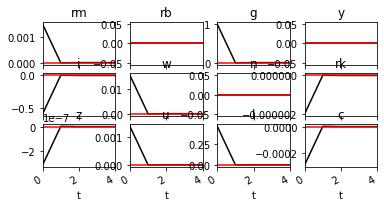

In [109]:
exo_names, endo_names, controls = make_roles(optimal_states, data)
m = make_adjacency(exo_names, endo_names, controls, data=data)
real_dag = dag(m)

x_0 = pd.Series(np.full(len(real_dag.nodes), np.nan), index=real_dag.nodes)
shock_amt = 1
shock_var = 'g'
if shock_var in exo_names:
    shock_index = np.where(data.columns.values == shock_var)[0][0]
elif shock_var + '_1' in endo_names:
    shock_index = np.where(data.columns.values == shock_var.rstrip('_1'))[0][0]
else:
    raise ValueError('Cannot shock control variable {}'.format(shock_var))

x_0[shock_index] = shock_amt
x_0[int(len(real_dag.nodes)/2):] = 0

real_irf = real_dag.calculate_irf(x_0, T=5)
plt = real_dag.plot_irf(real_irf)
plt.show()

In [119]:
# Some guess at what the states may be
guess_states = ['rm_1', 'z', 'g_1', 'n'] 

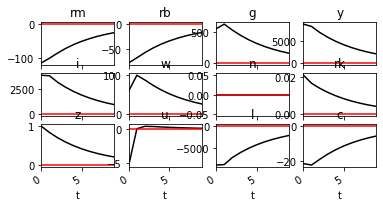

In [120]:
exo_names, endo_names, controls = make_roles(guess_states, data)
m = make_adjacency(exo_names, endo_names, controls, data=data)
real_dag = dag(m)

x_0 = pd.Series(np.full(len(real_dag.nodes), np.nan), index=real_dag.nodes)
shock_amt = 1
shock_var = 'z'
shock_index = np.where(data.columns.values == shock_var)[0][0]
x_0[shock_index] = shock_amt
x_0[int(len(real_dag.nodes)/2):] = 0

real_irf = real_dag.calculate_irf(x_0, T=10)
plt = real_dag.plot_irf(real_irf)
plt.show()

In [124]:
df = pd.DataFrame(columns=['x', 'y', 'pcorr', 'pval(t)'])
for x in list(combinations(controls, 2)):
    df = df.append({'x': x[0],
                    'y': x[1],
                    'z': exo_states + endo_states,
                    'pcorr': partial_correlation(x[0], x[1], exo_states + endo_states, data=data)[0],
                    'pval(t)': partial_correlation(x[0], x[1], exo_states + endo_states, data=data)[1]},
                   ignore_index=True)
df.sort_values(by='pval(t)', ascending=True)

,x,y,pcorr,pval(t),z
7,y,i,0.828446,2.054248e-26,"[z, g, rm_1]"
10,y,u,-0.515436,4.076818e-08,"[z, g, rm_1]"
15,i,u,-0.504753,8.556412e-08,"[z, g, rm_1]"
4,rb,u,-0.400776,3.596742e-05,"[z, g, rm_1]"
1,rb,i,0.298795,2.530361e-03,"[z, g, rm_1]"
6,rb,c,0.283531,4.255469e-03,"[z, g, rm_1]"
12,y,c,-0.267159,7.209210e-03,"[z, g, rm_1]"
11,y,l,0.217283,2.989139e-02,"[z, g, rm_1]"
2,rb,w,-0.203364,4.242495e-02,"[z, g, rm_1]"
9,y,rk,0.201293,4.461894e-02,"[z, g, rm_1]"
